In [68]:
# loading the necessary libraries
import tarfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import networkx as nx
import scipy.io as sio
from scipy.io import loadmat
import random
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import f_oneway, ttest_ind
import community as community_louvain 
import json
from scipy.stats import zscore, norm
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

We will conduct a functional network analysis by systematically aligning our methodology and analysis with each research question. The first question we aim to address is: 

**1. How does the global efficiency of functional brain networks vary across ADHD subtypes (Combined and Inattentive)?**

This analysis will provide insights into subtype-specific differences in brain network organization, enhancing our understanding of ADHD’s neurobiological underpinnings.

In [2]:
# Function to extract dataset if not already extracted
def extract_dataset(tar_path, extracted_path):
    if not os.path.exists(extracted_path):
        with tarfile.open(tar_path) as tar_file:
            tar_file.extractall(extracted_path)
    print(f"Dataset extracted to: {extracted_path}")


# Function to apply statistical significance thresholding
def apply_statistical_threshold(matrix, time_series, alpha=0.05):

    num_rois = matrix.shape[0]
    significant_matrix = np.zeros((num_rois, num_rois))

    for i in range(num_rois):
        for j in range(i + 1, num_rois):
            # Perform correlation significance test
            corr, p_value = pearsonr(time_series[:, i], time_series[:, j])
            if p_value < alpha:  # Retain only significant correlations
                significant_matrix[i, j] = matrix[i, j]
                significant_matrix[j, i] = matrix[j, i]

    return significant_matrix

# Function to apply sparsity thresholding
def apply_sparsity_threshold(matrix, density=0.2):

    num_edges = int(density * (matrix.shape[0] * (matrix.shape[0] - 1)) / 2)
    flat_matrix = matrix[np.triu_indices_from(matrix, k=1)]
    sorted_indices = np.argsort(flat_matrix)[::-1]  # Sort edges by weight (descending)
    top_indices = sorted_indices[:num_edges]

    thresholded_matrix = np.zeros_like(matrix)
    upper_indices = np.triu_indices_from(matrix, k=1)
    for idx in top_indices:
        i, j = upper_indices[0][idx], upper_indices[1][idx]
        thresholded_matrix[i, j] = matrix[i, j]
        thresholded_matrix[j, i] = matrix[i, j]

    return thresholded_matrix



# Function to apply proportional thresholding
def apply_proportional_threshold(matrix, proportion=0.4):
    flat_matrix = matrix[np.triu_indices_from(matrix, k=1)]
    threshold = np.percentile(flat_matrix, 100 * (1 - proportion))
    thresholded_matrix = np.where(matrix >= threshold, matrix, 0)
    np.fill_diagonal(thresholded_matrix, 0)
    return thresholded_matrix

In [3]:
# Getting the data
tar_path = "/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/rois_1000_beijing.tar"  # Path to the tar file
extracted_path = "/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing"  # Path for extracted files
phenotype_path = "/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing/rois_1000_beijing/"  # Path to the 'phenotype' files
phenotype_folder = phenotype_path  # Path where phenotype CSVs will be located
rois_path = os.path.join(phenotype_folder, "rois")  # Path to the 'rois' folder

# Extract dataset
extract_dataset(tar_path, extracted_path)


# Load the files
file1_path = '/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing/rois_1000_beijing/Peking_1_phenotypic.csv'
file2_path = '/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing/rois_1000_beijing/Peking_2_phenotypic.csv'
file3_path = '/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing/rois_1000_beijing/Peking_3_phenotypic.csv'


file1 = pd.read_csv(file1_path)
file2 = pd.read_csv(file2_path)
file3 = pd.read_csv(file3_path)


# Combine the three files
combined_from_files = pd.concat([file1, file2, file3], ignore_index=True)

# save the combined file
combined_file = 'combined_phenotype_file.csv'
combined_from_files.to_csv(combined_file, index=False)



Dataset extracted to: /Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing


In [4]:
# load the combined phenotype file
phenotype_data = pd.read_csv('combined_phenotype_file.csv')
print(phenotype_data.head())

   ScanDir ID  Site  Gender    Age  Handedness  DX Secondary Dx   \
0     1056121     1       1  13.92           1   0           NaN   
1     1113498     1       0  14.83           1   0           NaN   
2     1133221     1       1  12.33           1   1           ODD   
3     1139030     1       0  11.33           1   0           NaN   
4     1186237     1       1  13.92           1   3           NaN   

   ADHD Measure  ADHD Index  Inattentive  ...  Performance IQ  Full2 IQ  \
0             1        30.0         15.0  ...             136       NaN   
1             1        20.0         11.0  ...             135       NaN   
2             1        64.0         32.0  ...             108       NaN   
3             1        32.0         18.0  ...              86       NaN   
4             1        48.0         31.0  ...             103       NaN   

   Full4 IQ  Med Status  QC_Rest_1  QC_Rest_2  QC_Rest_3  QC_Rest_4  \
0       135           1          1        NaN        NaN        NaN  

In [5]:
# unique values in DX column
print(phenotype_data['DX'].unique())

[0 1 3]


Phenotypical Data has the following Diagnostic Data in the files

- 0 - Typically Developing Control (TDC)
- 1 - ADHD-Inattentive Type
- 3 - ADHD-Hyper/Impulsive

**The following code section does the following to answer the question 1**

- Combining all phenotype files to include all the subjects
- Filtering ADHD subjects with ADHD subtypes (Combined, Inattentive)
- Construction of Functional Networks by:
    - Computer the connectivity matrix for each subject
    - Apply thresholding and calculate network statistics/metrics - global efficiency, average clustering, betweenness centrality, degree distribution, average path length.


In [6]:
# # Function to retain top N% of strongest connections
# def retain_top_connections(matrix, top_percent=10):
#     num_connections = int(np.ceil(top_percent / 100 * matrix.size))
#     threshold = np.sort(matrix.flatten())[-num_connections]
#     return np.where(matrix >= threshold, matrix, 0)

# # Thresholding method
# thresholding_method = "proportional"  # Choose from "proportional", "statistical", "sparsity"
# threshold_density = 0.4  # Adjust density for proportional/sparsity thresholding

# # Filter ADHD subjects
# adhd_subjects = phenotype_data[phenotype_data['DX'].isin([1, 3])]
# subject_ids = adhd_subjects['ScanDir ID'].astype(str).tolist()

# # Match .mat files with subject IDs
# subject_files = [
#     f for f in os.listdir(rois_path) if f.endswith(".mat") and f.startswith("tseries_rois")
# ]
# selected_subject_files = [
#     f for f in subject_files if any(sub_id in f for sub_id in subject_ids)
# ]

# # Process each subject
# subject_metrics = []

# for file_name in tqdm(selected_subject_files, desc="Processing Subjects"):
#     try:
#         # Load time-series data
#         file_path = os.path.join(rois_path, file_name)
#         data = loadmat(file_path)
#         tseries = data["tseries"]

#         # Handle constant and near-constant ROIs
#         roi_std = np.std(tseries, axis=0)
#         is_constant = roi_std == 0
#         near_constant = (roi_std > 0) & (roi_std < 1e-6)
#         if np.any(is_constant):
#             print(f"Subject-specific constant ROIs detected for {np.sum(is_constant)} ROIs. Replacing with zeros.")
#             tseries[:, is_constant] = 0
#         if np.any(near_constant):
#             print(f"Subject-specific near-constant ROIs detected for {np.sum(near_constant)} ROIs. Adding noise.")
#             tseries[:, near_constant] += np.random.normal(0, 1e-6, size=tseries[:, near_constant].shape)

#         # Handle NaN values
#         if np.isnan(tseries).any():
#             print(f"NaN values detected for {file_name}. Replacing with zeros.")
#             tseries = np.nan_to_num(tseries)

#         # Compute Pearson correlation matrix
#         correlation_matrix = np.corrcoef(tseries.T)

#         # Apply thresholding
#         if thresholding_method == "proportional":
#             thresholded_matrix = apply_proportional_threshold(correlation_matrix, proportion=threshold_density)
#         elif thresholding_method == "statistical":
#             thresholded_matrix = apply_statistical_threshold(correlation_matrix, tseries, alpha=0.05)
#         elif thresholding_method == "sparsity":
#             thresholded_matrix = apply_sparsity_threshold(correlation_matrix, density=threshold_density)
#         else:
#             raise ValueError(f"Unknown thresholding method: {thresholding_method}")

#         # Fallback: Retain top connections if matrix is too sparse
#         if np.sum(thresholded_matrix > 0) < 10:  # Arbitrary threshold for sparsity
#             print(f"Thresholded matrix too sparse for {file_name}. Retaining top connections.")
#             thresholded_matrix = retain_top_connections(correlation_matrix, top_percent=10)

#         # Save the thresholded matrix for later use
#         subject_id = file_name.split("_")[3]
#         output_matrix_path = f"{subject_id}_matrix.npy"
#         np.save(output_matrix_path, thresholded_matrix)

#         # Create graph and calculate metrics
#         G = nx.from_numpy_array(thresholded_matrix, create_using=nx.Graph)

#         # Check connectivity
#         is_connected = nx.is_connected(G)
#         if not is_connected:
#             print(f"Subject {subject_id} has a disconnected graph.")
#             num_components = nx.number_connected_components(G)
#             print(f"Number of connected components: {num_components}")

#         # Compute global metrics
#         global_efficiency = nx.global_efficiency(G)
#         avg_clustering = nx.average_clustering(G)
#         avg_shortest_path = nx.average_shortest_path_length(G) if is_connected else None

#         # Degree distribution
#         degree_sequence = [deg for node, deg in G.degree()]

#         # Betweenness centrality
#         betweenness = nx.betweenness_centrality(G, weight="weight")

#         # Save metrics
#         subject_metrics.append({
#             "Subject_ID": subject_id,
#             "Global_Efficiency": global_efficiency,
#             "Avg_Clustering": avg_clustering,
#             "Avg_Shortest_Path": avg_shortest_path,
#             "Degree_Distribution": degree_sequence,
#             "Betweenness_Centrality": betweenness
#         })

#     except Exception as e:
#         print(f"Error processing {file_name}: {e}")

# # Save results to CSV
# metrics_df = pd.DataFrame(subject_metrics)
# output_file_path = "functional_network_metrics.csv"
# metrics_df.to_csv(output_file_path, index=False)
# print(f"Metrics saved to {output_file_path}")


In [7]:
# ******************* CODE WITH REMOVING THE ROIs ********************
# Function to retain top N% of strongest connections
def retain_top_connections(matrix, top_percent=10):
    num_connections = int(np.ceil(top_percent / 100 * matrix.size))
    threshold = np.sort(matrix.flatten())[-num_connections]
    return np.where(matrix >= threshold, matrix, 0)

# Thresholding method
thresholding_method = "proportional"  # Choose from "proportional", "statistical", "sparsity"
threshold_density = 0.4  # Adjust density for proportional/sparsity thresholding

# Filter ADHD subjects
adhd_subjects = phenotype_data[phenotype_data['DX'].isin([1, 3])]
subject_ids = adhd_subjects['ScanDir ID'].astype(str).tolist()

# Match .mat files with subject IDs
subject_files = [
    f for f in os.listdir(rois_path) if f.endswith(".mat") and f.startswith("tseries_rois")
]
selected_subject_files = [
    f for f in subject_files if any(sub_id in f for sub_id in subject_ids)
]

# Process each subject
subject_metrics = []
constant_rois_log = {}  # Dictionary to store constant ROI indices for each subject

for file_name in tqdm(selected_subject_files, desc="Processing Subjects"):
    try:
        # Load time-series data
        file_path = os.path.join(rois_path, file_name)
        data = loadmat(file_path)
        tseries = data["tseries"]

        # Identify and remove constant ROIs
        roi_std = np.std(tseries, axis=0)
        is_constant = roi_std == 0
        constant_rois_indices = np.where(is_constant)[0]  # Get indices of constant ROIs
        if np.any(is_constant):
            print(f"Subject-specific constant ROIs detected for {np.sum(is_constant)} ROIs.")
            constant_rois_log[file_name] = constant_rois_indices.tolist()
            tseries = tseries[:, ~is_constant]  # Remove constant ROIs

        # Handle NaN values
        if np.isnan(tseries).any():
            print(f"NaN values detected for {file_name}. Replacing with zeros.")
            tseries = np.nan_to_num(tseries)

        # Compute Pearson correlation matrix
        correlation_matrix = np.corrcoef(tseries.T)

        # Apply thresholding
        if thresholding_method == "proportional":
            thresholded_matrix = apply_proportional_threshold(correlation_matrix, proportion=threshold_density)
        elif thresholding_method == "statistical":
            thresholded_matrix = apply_statistical_threshold(correlation_matrix, tseries, alpha=0.05)
        elif thresholding_method == "sparsity":
            thresholded_matrix = apply_sparsity_threshold(correlation_matrix, density=threshold_density)
        else:
            raise ValueError(f"Unknown thresholding method: {thresholding_method}")

        # Fallback: Retain top connections if matrix is too sparse
        if np.sum(thresholded_matrix > 0) < 10:  # Arbitrary threshold for sparsity
            print(f"Thresholded matrix too sparse for {file_name}. Retaining top connections.")
            thresholded_matrix = retain_top_connections(correlation_matrix, top_percent=10)

        # Save the thresholded matrix for later use
        subject_id = file_name.split("_")[3]
        output_matrix_path = f"{subject_id}_matrix.npy"
        np.save(output_matrix_path, thresholded_matrix)

        # Create graph and calculate metrics
        G = nx.from_numpy_array(thresholded_matrix, create_using=nx.Graph)

        # Check connectivity
        is_connected = nx.is_connected(G)
        if not is_connected:
            print(f"Subject {subject_id} has a disconnected graph.")
            num_components = nx.number_connected_components(G)
            print(f"Number of connected components: {num_components}")

        # Compute global metrics
        global_efficiency = nx.global_efficiency(G)
        avg_clustering = nx.average_clustering(G)
        avg_shortest_path = nx.average_shortest_path_length(G) if is_connected else None

        # Degree distribution
        degree_sequence = [deg for node, deg in G.degree()]

        # Betweenness centrality
        betweenness = nx.betweenness_centrality(G, weight="weight")

        # Save metrics
        subject_metrics.append({
            "Subject_ID": subject_id,
            "Global_Efficiency": global_efficiency,
            "Avg_Clustering": avg_clustering,
            "Avg_Shortest_Path": avg_shortest_path,
            "Degree_Distribution": degree_sequence,
            "Betweenness_Centrality": betweenness
        })

    except Exception as e:
        print(f"Error processing {file_name}: {e}")

# Save results to CSV
metrics_df = pd.DataFrame(subject_metrics)
output_file_path = "functional_network_metrics_roi_removed.csv"
metrics_df.to_csv(output_file_path, index=False)
print(f"Metrics saved to {output_file_path}")

# Save constant ROIs log
constant_rois_log_path = "constant_rois_log.json"
import json
with open(constant_rois_log_path, "w") as f:
    json.dump(constant_rois_log, f, indent=4)
print(f"Log of constant ROIs saved to {constant_rois_log_path}")


Processing Subjects:   1%|▏         | 1/78 [01:56<2:30:00, 116.89s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Subjects:   3%|▎         | 2/78 [03:43<2:20:20, 110.80s/it]

Subject-specific constant ROIs detected for 14 ROIs.


Processing Subjects:   5%|▌         | 4/78 [07:18<2:13:54, 108.58s/it]

Subject-specific constant ROIs detected for 19 ROIs.


Processing Subjects:  12%|█▏        | 9/78 [16:26<2:06:56, 110.38s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Subjects:  13%|█▎        | 10/78 [18:13<2:03:46, 109.21s/it]

Subject-specific constant ROIs detected for 12 ROIs.


Processing Subjects:  17%|█▋        | 13/78 [23:38<1:57:47, 108.72s/it]

Subject 3291029 has a disconnected graph.
Number of connected components: 10


Processing Subjects:  23%|██▎       | 18/78 [32:38<1:47:58, 107.98s/it]

Subject-specific constant ROIs detected for 18 ROIs.


Processing Subjects:  31%|███       | 24/78 [43:50<1:42:19, 113.69s/it]

Subject 1843546 has a disconnected graph.
Number of connected components: 2


Processing Subjects:  32%|███▏      | 25/78 [45:40<1:39:34, 112.73s/it]

Subject-specific constant ROIs detected for 4 ROIs.


Processing Subjects:  40%|███▉      | 31/78 [56:51<1:27:24, 111.58s/it]

Subject-specific constant ROIs detected for 16 ROIs.


Processing Subjects:  46%|████▌     | 36/78 [1:06:15<1:19:20, 113.35s/it]

Subject-specific constant ROIs detected for 2 ROIs.


Processing Subjects:  56%|█████▋    | 44/78 [1:21:19<1:03:29, 112.04s/it]

Subject-specific constant ROIs detected for 1 ROIs.
Subject 1159908 has a disconnected graph.
Number of connected components: 3


Processing Subjects:  58%|█████▊    | 45/78 [1:23:14<1:02:04, 112.88s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Subjects:  65%|██████▌   | 51/78 [1:34:29<49:58, 111.06s/it]  

Subject-specific constant ROIs detected for 1 ROIs.


Processing Subjects:  77%|███████▋  | 60/78 [1:50:35<32:10, 107.24s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Subjects:  78%|███████▊  | 61/78 [1:52:18<30:00, 105.93s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Subjects:  95%|█████████▍| 74/78 [2:15:22<07:07, 106.77s/it]

Subject 3870624 has a disconnected graph.
Number of connected components: 2


Processing Subjects:  96%|█████████▌| 75/78 [2:17:20<05:29, 109.98s/it]

Subject-specific constant ROIs detected for 3 ROIs.


Processing Subjects: 100%|██████████| 78/78 [2:22:35<00:00, 109.68s/it]

Metrics saved to functional_network_metrics_roi_removed.csv
Log of constant ROIs saved to constant_rois_log.json


In [8]:
# Load the metrics data
metrics_df = pd.read_csv("functional_network_metrics_roi_removed.csv")

# Display the metrics data
print(metrics_df.head())

   Subject_ID  Global_Efficiency  Avg_Clustering  Avg_Shortest_Path  \
0     1771270           0.694610        0.714474           1.632743   
1     7689953           0.699951        0.586384           1.600294   
2     4073815           0.696014        0.660957           1.623916   
3     4091983           0.700001        0.535336           1.599999   
4     2950754           0.698751        0.644883           1.607491   

                                 Degree_Distribution  \
0  [649, 556, 694, 614, 641, 603, 451, 441, 574, ...   
1  [232, 268, 299, 271, 227, 260, 242, 386, 258, ...   
2  [428, 507, 137, 539, 43, 542, 608, 251, 97, 37...   
3  [477, 500, 559, 591, 483, 569, 392, 321, 430, ...   
4  [536, 595, 305, 469, 121, 338, 252, 159, 326, ...   

                              Betweenness_Centrality  
0  {0: 0.0009368910208364563, 1: 0.00225515179838...  
1  {0: 0.000667143829140489, 1: 0.000653889315978...  
2  {0: 0.0018415453540149547, 1: 0.00140556914196...  
3  {0: 0.0008597

In [9]:
# counting the number of subjects in network metrics file
num_subjects = metrics_df.shape[0]
print(f"Number of subjects: {num_subjects}")

Number of subjects: 78


In [11]:
# counting how many subjects have NaNs in the avg_shortest_path column
num_missing_shortest_path = metrics_df["Avg_Shortest_Path"].isnull().sum()
print(f"Number of subjects with missing shortest path: {num_missing_shortest_path}")

# removing the rows with NaN values
metrics_df = metrics_df.dropna(subset=["Avg_Shortest_Path"])
# saving the cleaned data
metrics_df.to_csv("functional_network_metrics_roi_removed_cleaned.csv", index=False)

# counting the number of subjects in network metrics file
num_subjects = metrics_df.shape[0]
print(f"Number of subjects: {num_subjects}")

Number of subjects with missing shortest path: 4
Number of subjects: 74


**Combined thresholded matrix for the subjects with ADHD Subtypes**

**Explanation of the Code**

Initialization:
- combined_thresholded_matrix is initialized to None to accumulate matrices, and subject_count tracks the number of valid subjects processed.

Loading and NaN Handling:
- Each thresholded matrix is loaded using the subject ID.
- Any NaN values in the thresholded matrix are replaced with zeros (np.nan_to_num()), ensuring consistent dimensions and numerical stability.

Matrix Aggregation:
- The loaded matrix is either added to the accumulator (combined_thresholded_matrix) or used to initialize it (for the first subject).

Averaging Across Subjects:
- After processing all valid subjects, the combined matrix is averaged by dividing by the subject_count.

Saving and Visualization:
- The combined thresholded matrix is saved as a .npy file for future use.
- A heatmap of the combined matrix is plotted to visualize group-level connectivity patterns.

Processing Thresholded Matrices: 100%|██████████| 74/74 [00:00<00:00, 564.01it/s]


Combined thresholded matrix saved to combined_thresholded_matrix_q1.npy


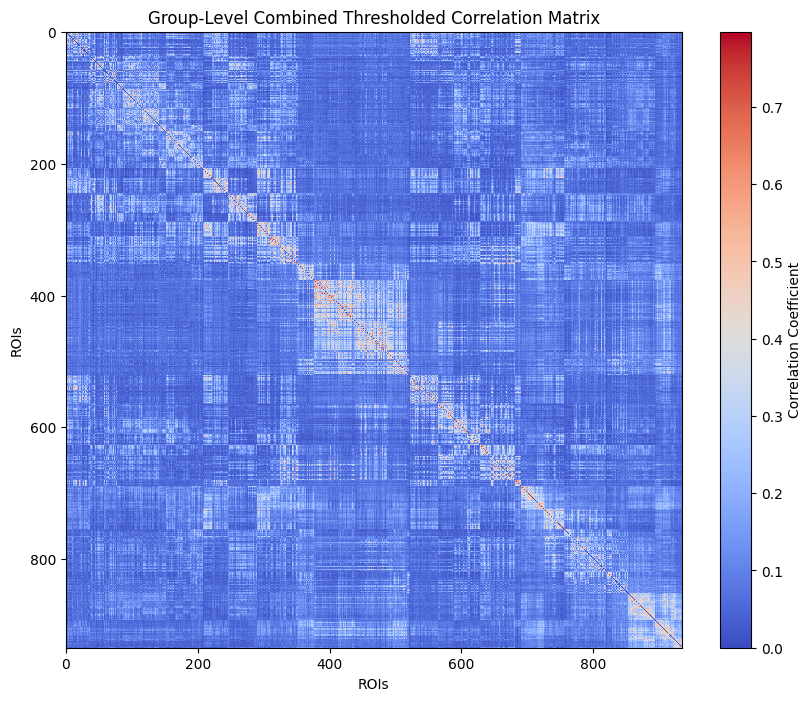

In [19]:
# Helper function to resize matrix to a target size
def resize_matrix(matrix, target_size):
    """
    Resizes a matrix to the target size by trimming or zero-padding.
    """
    current_size = matrix.shape[0]
    if current_size > target_size:
        # Trim the matrix
        return matrix[:target_size, :target_size]
    elif current_size < target_size:
        # Zero-pad the matrix
        padding = target_size - current_size
        return np.pad(matrix, ((0, padding), (0, padding)), mode="constant", constant_values=0)
    else:
        return matrix

# Manually specify the valid subject matrix file names
valid_subject_files = [
    '2228148_matrix.npy', '4055710_matrix.npy', '3691107_matrix.npy', '4073815_matrix.npy', '3827352_matrix.npy',
    '5993008_matrix.npy', '3205761_matrix.npy', '4091983_matrix.npy', '1186237_matrix.npy', '7253183_matrix.npy',
    '2950754_matrix.npy', '1282248_matrix.npy', '3856956_matrix.npy', '3976121_matrix.npy', '2174595_matrix.npy',
    '2737106_matrix.npy', '4053388_matrix.npy', '4221029_matrix.npy', '2884672_matrix.npy', '1791543_matrix.npy',
    '3910672_matrix.npy', '1561488_matrix.npy', '8278680_matrix.npy', '2207418_matrix.npy', '2367157_matrix.npy',
    '4095748_matrix.npy', '2529026_matrix.npy', '4006710_matrix.npy', '1628610_matrix.npy', '5150328_matrix.npy',
    '6383713_matrix.npy', '1947991_matrix.npy', '1356553_matrix.npy', '2940712_matrix.npy', '3390312_matrix.npy',
    '2780647_matrix.npy', '3803759_matrix.npy', '4225073_matrix.npy', '5193577_matrix.npy', '2031422_matrix.npy',
    '3446674_matrix.npy', '3672300_matrix.npy', '2919220_matrix.npy', '3561920_matrix.npy', '1094669_matrix.npy',
    '7689953_matrix.npy', '2141250_matrix.npy', '1771270_matrix.npy', '6500128_matrix.npy', '4028266_matrix.npy',
    '2697768_matrix.npy', '1399863_matrix.npy', '2276801_matrix.npy', '1240299_matrix.npy', '4334113_matrix.npy',
    '1809715_matrix.npy', '1341865_matrix.npy', '2907951_matrix.npy', '3194757_matrix.npy', '2196753_matrix.npy',
    '9002207_matrix.npy', '1133221_matrix.npy', '1643780_matrix.npy', '7390867_matrix.npy', '2897046_matrix.npy',
    '2984158_matrix.npy', '2524687_matrix.npy', '4241194_matrix.npy', '2601519_matrix.npy', '2910270_matrix.npy',
    '4075719_matrix.npy', '3712305_matrix.npy', '3983607_matrix.npy', '9210521_matrix.npy'
]

# Path to the directory containing subject matrix files
matrix_directory = "."  # Current directory

# Find the smallest matrix size among valid subjects
min_size = min(
    np.load(os.path.join(matrix_directory, file_name)).shape[0]
    for file_name in valid_subject_files
)

# Initialize accumulator for thresholded matrices
combined_thresholded_matrix = None
subject_count = 0

# Load and aggregate thresholded matrices
for file_name in tqdm(valid_subject_files, desc="Processing Thresholded Matrices"):
    try:
        # Load the saved thresholded matrix
        thresholded_matrix_path = os.path.join(matrix_directory, file_name)
        thresholded_matrix = np.load(thresholded_matrix_path)

        # Handle NaN values
        if np.isnan(thresholded_matrix).any():
            print(f"NaN values detected in the thresholded matrix for file {file_name}. Replacing with zeros.")
            thresholded_matrix = np.nan_to_num(thresholded_matrix)

        # Resize matrix to the smallest size
        resized_matrix = resize_matrix(thresholded_matrix, min_size)

        # Aggregate matrices
        if combined_thresholded_matrix is None:
            combined_thresholded_matrix = np.copy(resized_matrix)
        else:
            combined_thresholded_matrix += resized_matrix
        subject_count += 1

    except Exception as e:
        print(f"Error loading thresholded matrix for {file_name}: {e}")

# Compute the average thresholded matrix
if subject_count > 0:
    combined_thresholded_matrix /= subject_count

    # Save the combined thresholded matrix
    combined_matrix_path = "combined_thresholded_matrix_q1.npy"
    np.save(combined_matrix_path, combined_thresholded_matrix)
    print(f"Combined thresholded matrix saved to {combined_matrix_path}")

    # Plot the combined thresholded matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(combined_thresholded_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label="Correlation Coefficient")
    plt.title("Group-Level Combined Thresholded Correlation Matrix")
    plt.xlabel("ROIs")
    plt.ylabel("ROIs")
    plt.show()

else:
    print("No valid thresholded matrices were processed for the combined matrix.")

In [20]:
print("Matrix value range:", np.min(combined_thresholded_matrix), np.max(combined_thresholded_matrix))

Matrix value range: 0.0 0.7973731959518042


In [21]:
print("NaN values in combined matrix:", np.isnan(combined_thresholded_matrix).any())

NaN values in combined matrix: False


In [16]:
# let's see the dimensions of the combined thresholded matrix
print(combined_thresholded_matrix.shape)

(954, 954)


**Metrics Calculation for Neurotypical Controls**

In [22]:
# checking the unique DX values in the combined phenotype file
print(phenotype_data['DX'].unique())

[0 1 3]


In [23]:
# Paths
phenotype_path = "/Users/syednaqvi/university_data/Connectomics - Lab/Connectomics/Project/Datasets/extracted_rois_1000_beijing/rois_1000_beijing/"
rois_path = os.path.join(phenotype_path, "rois")

# Load the combined phenotype file
phenotype_file = 'combined_phenotype_file.csv'  # Path to the combined phenotype file
phenotype_data = pd.read_csv(phenotype_file)

# Filter neurotypical subjects (DX = 0)
neurotypical_subjects = phenotype_data[phenotype_data['DX'] == 0]
subject_ids = neurotypical_subjects['ScanDir ID'].astype(str).tolist()

# Match .mat files with neurotypical subject IDs
subject_files = [
    f for f in os.listdir(rois_path) if f.endswith(".mat") and f.startswith("tseries_rois")
]
selected_subject_files = [
    f for f in subject_files if any(sub_id in f for sub_id in subject_ids)
]

# Function to retain top N% of strongest connections
def retain_top_connections(matrix, top_percent=10):
    num_connections = int(np.ceil(top_percent / 100 * matrix.size))
    threshold = np.sort(matrix.flatten())[-num_connections]
    return np.where(matrix >= threshold, matrix, 0)

# Thresholding method
thresholding_method = "proportional"  # Choose from "proportional", "statistical", "sparsity"
threshold_density = 0.4  # Adjust density for proportional/sparsity thresholding

# Placeholder for metrics
subject_metrics = []
constant_rois_log = {}  # Dictionary to store constant ROI indices for each subject

# Processing each subject
for file_name in tqdm(selected_subject_files, desc="Processing Neurotypical Subjects"):
    try:
        # Load time-series data
        file_path = os.path.join(rois_path, file_name)
        data = loadmat(file_path)
        tseries = data["tseries"]

        # Identify and remove constant ROIs
        roi_std = np.std(tseries, axis=0)
        is_constant = roi_std == 0
        constant_rois_indices = np.where(is_constant)[0]  # Get indices of constant ROIs
        if np.any(is_constant):
            print(f"Subject-specific constant ROIs detected for {np.sum(is_constant)} ROIs.")
            constant_rois_log[file_name] = constant_rois_indices.tolist()
            tseries = tseries[:, ~is_constant]  # Remove constant ROIs

        # Handle NaN values
        if np.isnan(tseries).any():
            print(f"NaN values detected for {file_name}. Replacing with zeros.")
            tseries = np.nan_to_num(tseries)

        # Compute Pearson correlation matrix
        correlation_matrix = np.corrcoef(tseries.T)

        # Apply thresholding
        if thresholding_method == "proportional":
            num_connections = int(threshold_density * correlation_matrix.size)
            threshold_value = np.sort(correlation_matrix.flatten())[-num_connections]
            thresholded_matrix = np.where(correlation_matrix >= threshold_value, correlation_matrix, 0)
        elif thresholding_method == "statistical":
            raise NotImplementedError("Statistical thresholding is not implemented.")
        elif thresholding_method == "sparsity":
            raise NotImplementedError("Sparsity thresholding is not implemented.")
        else:
            raise ValueError(f"Unknown thresholding method: {thresholding_method}")

        # Fallback: Retain top connections if the matrix is too sparse
        if np.sum(thresholded_matrix > 0) < 10:  # Arbitrary threshold for sparsity
            print(f"Thresholded matrix too sparse for {file_name}. Retaining top connections.")
            thresholded_matrix = retain_top_connections(correlation_matrix, top_percent=10)

        # Save the thresholded matrix for later use
        subject_id = file_name.split("_")[3]
        output_matrix_path = f"neurotypical_{subject_id}_matrix.npy"
        np.save(output_matrix_path, thresholded_matrix)

        # Create graph and calculate metrics
        G = nx.from_numpy_array(thresholded_matrix, create_using=nx.Graph)

        # Check connectivity
        is_connected = nx.is_connected(G)
        if not is_connected:
            print(f"Subject {subject_id} has a disconnected graph.")
            num_components = nx.number_connected_components(G)
            print(f"Number of connected components: {num_components}")

        # Compute global metrics
        global_efficiency = nx.global_efficiency(G)
        avg_clustering = nx.average_clustering(G)
        avg_shortest_path = nx.average_shortest_path_length(G) if is_connected else None

        # Degree distribution
        degree_sequence = [deg for node, deg in G.degree()]

        # Betweenness centrality
        betweenness = nx.betweenness_centrality(G, weight="weight")

        # Save metrics
        subject_metrics.append({
            "Subject_ID": subject_id,
            "Global_Efficiency": global_efficiency,
            "Avg_Clustering": avg_clustering,
            "Avg_Shortest_Path": avg_shortest_path,
            "Degree_Distribution": degree_sequence,
            "Betweenness_Centrality": betweenness
        })

    except Exception as e:
        print(f"Error processing {file_name}: {e}")

# Save results to CSV
metrics_df = pd.DataFrame(subject_metrics)
output_file_path = "functional_network_metrics_neurotypical.csv"
metrics_df.to_csv(output_file_path, index=False)
print(f"Metrics saved to {output_file_path}")

# Save constant ROIs log
constant_rois_log_path = "constant_rois_log_neurotypical.json"
import json
with open(constant_rois_log_path, "w") as f:
    json.dump(constant_rois_log, f, indent=4)
print(f"Log of constant ROIs saved to {constant_rois_log_path}")

Processing Neurotypical Subjects:   5%|▌         | 6/116 [10:59<3:19:32, 108.84s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Neurotypical Subjects:  23%|██▎       | 27/116 [49:42<2:48:03, 113.30s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Neurotypical Subjects:  25%|██▌       | 29/116 [53:36<2:47:22, 115.43s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Neurotypical Subjects:  27%|██▋       | 31/116 [57:18<2:40:13, 113.10s/it]

Subject 2493190 has a disconnected graph.
Number of connected components: 8


Processing Neurotypical Subjects:  41%|████▏     | 48/116 [1:29:02<2:05:43, 110.93s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Neurotypical Subjects:  53%|█████▎    | 62/116 [1:55:18<1:42:49, 114.24s/it]

Subject-specific constant ROIs detected for 1 ROIs.


Processing Neurotypical Subjects:  54%|█████▍    | 63/116 [1:57:16<1:41:48, 115.26s/it]

Subject 5600820 has a disconnected graph.
Number of connected components: 3


Processing Neurotypical Subjects:  62%|██████▏   | 72/116 [2:14:52<1:25:29, 116.59s/it]

Subject-specific constant ROIs detected for 3 ROIs.


Processing Neurotypical Subjects:  71%|███████   | 82/116 [2:34:11<1:04:59, 114.70s/it]

Subject-specific constant ROIs detected for 4 ROIs.


Processing Neurotypical Subjects:  91%|█████████▏| 106/116 [3:21:43<19:06, 114.63s/it] 

Subject-specific constant ROIs detected for 3 ROIs.


Processing Neurotypical Subjects: 100%|██████████| 116/116 [3:40:09<00:00, 113.87s/it]

Metrics saved to functional_network_metrics_neurotypical.csv
Log of constant ROIs saved to constant_rois_log_neurotypical.json


In [24]:
# loading and displaying the metrics data
metrics_df = pd.read_csv("functional_network_metrics_neurotypical.csv")
print(metrics_df.head())

   Subject_ID  Global_Efficiency  Avg_Clustering  Avg_Shortest_Path  \
0     1093743           0.699681        0.552568           1.600656   
1     2833684           0.698826        0.645156           1.605784   
2     2377207           0.699682        0.562041           1.600650   
3     1408093           0.698394        0.675429           1.608378   
4     3707771           0.699685        0.542369           1.600630   

                                 Degree_Distribution  \
0  [519, 441, 385, 435, 387, 387, 434, 262, 356, ...   
1  [541, 583, 394, 557, 315, 403, 282, 449, 557, ...   
2  [334, 449, 368, 318, 273, 374, 413, 397, 339, ...   
3  [287, 464, 552, 357, 463, 342, 159, 313, 617, ...   
4  [273, 352, 422, 405, 505, 470, 345, 331, 363, ...   

                              Betweenness_Centrality  
0  {0: 0.0005092278254428739, 1: 0.00147477668926...  
1  {0: 0.000992002257356248, 1: 0.000626063646864...  
2  {0: 0.0005268634211292072, 1: 0.00091043762730...  
3  {0: 0.0004607

In [25]:
# counting how many subjects have NaNs in the avg_shortest_path column
num_missing_shortest_path = metrics_df["Avg_Shortest_Path"].isnull().sum()
print(f"Number of subjects with missing shortest path: {num_missing_shortest_path}")

# removing the rows with NaN values
metrics_df = metrics_df.dropna(subset=["Avg_Shortest_Path"])
# saving the cleaned data
metrics_df.to_csv("functional_network_metrics_neurotypical_cleaned.csv", index=False)

# counting the number of subjects in network metrics file
num_subjects = metrics_df.shape[0]
print(f"Number of subjects: {num_subjects}")

Number of subjects with missing shortest path: 2
Number of subjects: 114


Minimum matrix size determined: 950


Processing Neurotypical Matrices: 100%|██████████| 114/114 [00:00<00:00, 260.87it/s]


Combined thresholded matrix saved to combined_thresholded_matrix_neurotypical.npy


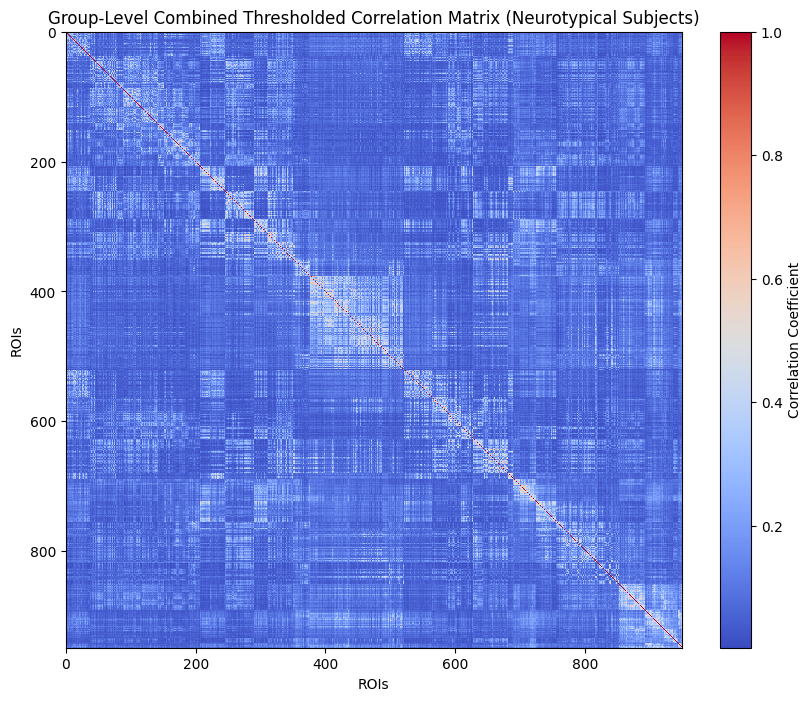

In [27]:
# Path to the directory containing neurotypical subject matrices
matrix_directory = "."  # Update this to the correct directory

# List all neurotypical matrices (ensure only neurotypical matrices are processed)
neurotypical_matrix_files = [f for f in os.listdir(matrix_directory) if f.startswith("neurotypical_") and f.endswith("_matrix.npy")]

# Ensure there are valid files
if len(neurotypical_matrix_files) == 0:
    raise ValueError("No valid neurotypical matrices found!")

# Find the smallest matrix size (ensure it's calculated correctly)
min_size = min(
    np.load(os.path.join(matrix_directory, file_name)).shape[0]
    for file_name in neurotypical_matrix_files
)

print(f"Minimum matrix size determined: {min_size}")

# Initialize accumulator for thresholded matrices
combined_thresholded_matrix = None
subject_count = 0

# Helper function to resize matrix
def resize_matrix(matrix, target_size):
    """
    Resizes a matrix to the target size by trimming or padding with zeros.
    """
    current_size = matrix.shape[0]
    if current_size > target_size:
        # Trim the matrix
        return matrix[:target_size, :target_size]
    elif current_size < target_size:
        # Pad the matrix
        padding = target_size - current_size
        return np.pad(matrix, ((0, padding), (0, padding)), mode="constant", constant_values=0)
    return matrix

# Load and aggregate thresholded matrices
for file_name in tqdm(neurotypical_matrix_files, desc="Processing Neurotypical Matrices"):
    try:
        # Load the saved thresholded matrix
        thresholded_matrix_path = os.path.join(matrix_directory, file_name)
        thresholded_matrix = np.load(thresholded_matrix_path)

        # Handle NaN values
        if np.isnan(thresholded_matrix).any():
            print(f"NaN values detected in the thresholded matrix for {file_name}. Replacing with zeros.")
            thresholded_matrix = np.nan_to_num(thresholded_matrix)

        # Resize the matrix to the smallest size
        resized_matrix = resize_matrix(thresholded_matrix, min_size)

        # Aggregate matrices
        if combined_thresholded_matrix is None:
            combined_thresholded_matrix = np.copy(resized_matrix)
        else:
            combined_thresholded_matrix += resized_matrix
        subject_count += 1

    except Exception as e:
        print(f"Error processing {file_name}: {e}")

# Compute the average thresholded matrix
if subject_count > 0:
    combined_thresholded_matrix /= subject_count

    # Save the combined thresholded matrix
    combined_matrix_path = "combined_thresholded_matrix_neurotypical.npy"
    np.save(combined_matrix_path, combined_thresholded_matrix)
    print(f"Combined thresholded matrix saved to {combined_matrix_path}")

    # Plot the combined thresholded matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(combined_thresholded_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label="Correlation Coefficient")
    plt.title("Group-Level Combined Thresholded Correlation Matrix (Neurotypical Subjects)")
    plt.xlabel("ROIs")
    plt.ylabel("ROIs")
    plt.show()

else:
    print("No valid matrices were processed for the combined matrix.")


In [28]:
# loading the combined thresholded matrix for neurotypical subjects separately and load the combined thresholded matrix for all subjects with ADHD separately
combined_thresholded_matrix_neurotypical = np.load("combined_thresholded_matrix_neurotypical.npy")
combined_thresholded_matrix_q1 = np.load("combined_thresholded_matrix_q1.npy")

# Display the shape of the matrices
print("Neurotypical matrix shape:", combined_thresholded_matrix_neurotypical.shape)
print("Q1 ADHD matrix shape:", combined_thresholded_matrix_q1.shape)

# Display the value range of the matrices
print("Neurotypical matrix value range:", np.min(combined_thresholded_matrix_neurotypical), np.max(combined_thresholded_matrix_neurotypical))
print("Q1 ADHD matrix value range:", np.min(combined_thresholded_matrix_q1), np.max(combined_thresholded_matrix_q1))

# Display the NaN values in the matrices
print("NaN values in neurotypical matrix:", np.isnan(combined_thresholded_matrix_neurotypical).any())
print("NaN values in Q1 ADHD matrix:", np.isnan(combined_thresholded_matrix_q1).any())

Neurotypical matrix shape: (950, 950)
Q1 ADHD matrix shape: (935, 935)
Neurotypical matrix value range: 0.002076148803526792 1.0
Q1 ADHD matrix value range: 0.0 0.7973731959518042
NaN values in neurotypical matrix: False
NaN values in Q1 ADHD matrix: False


In [31]:
adhd_matrix = np.load("combined_thresholded_matrix_q1.npy")
neurotypical_matrix = np.load("combined_thresholded_matrix_neurotypical.npy")

print("ADHD Matrix - Min:", np.min(adhd_matrix), "Max:", np.max(adhd_matrix))
print("Neurotypical Matrix - Min:", np.min(neurotypical_matrix), "Max:", np.max(neurotypical_matrix))

ADHD Matrix - Min: 0.0 Max: 0.7973731959518042
Neurotypical Matrix - Min: 0.002076148803526792 Max: 1.0


#### Calculating the Global Network Metrics for both subjects with ADHD subtypes and neurotypical subjects

In [30]:
# Load combined correlation matrices
adhd_matrix_path = "combined_thresholded_matrix_q1.npy"
neurotypical_matrix_path = "combined_thresholded_matrix_neurotypical.npy"

adhd_matrix = np.load(adhd_matrix_path)
neurotypical_matrix = np.load(neurotypical_matrix_path)

# Helper function to calculate network metrics
def calculate_network_metrics(correlation_matrix):
    """
    Calculate global network metrics for a given correlation matrix.
    """
    # Create graph from correlation matrix
    G = nx.from_numpy_array(correlation_matrix, create_using=nx.Graph)

    # Calculate network metrics
    global_efficiency = nx.global_efficiency(G)
    avg_clustering = nx.average_clustering(G)
    is_connected = nx.is_connected(G)

    # Check connectivity before calculating average shortest path length
    avg_shortest_path = nx.average_shortest_path_length(G) if is_connected else None

    return {
        "Global_Efficiency": global_efficiency,
        "Avg_Clustering": avg_clustering,
        "Avg_Shortest_Path": avg_shortest_path,
        "Is_Connected": is_connected,
    }

# Calculate metrics for ADHD combined matrix
adhd_metrics = calculate_network_metrics(adhd_matrix)
print("ADHD Combined & Inattentive Metrics:", adhd_metrics)

# Calculate metrics for Neurotypical combined matrix
neurotypical_metrics = calculate_network_metrics(neurotypical_matrix)
print("Neurotypical Metrics:", neurotypical_metrics)

# Save results to compare later
metrics_output = {
    "ADHD_Combined_Inattentive": adhd_metrics,
    "Neurotypical": neurotypical_metrics,
}

# Save metrics to JSON file because it is better suited for nested data structures for both ADHD and Neurotypical subjects
with open("group_level_metrics.json", "w") as f:
    json.dump(metrics_output, f, indent=4)
print("Group-level metrics saved to group_level_metrics.json")


ADHD Combined & Inattentive Metrics: {'Global_Efficiency': 1.0, 'Avg_Clustering': 1.0, 'Avg_Shortest_Path': 1.0, 'Is_Connected': True}
Neurotypical Metrics: {'Global_Efficiency': 1.0, 'Avg_Clustering': 1.0, 'Avg_Shortest_Path': 1.0, 'Is_Connected': True}
Group-level metrics saved to group_level_metrics.json


It looks like the matrix are not sparse, we will adjust the thresholding and recompute the network metrics

In [32]:
# Load combined correlation matrices
adhd_matrix = np.load("combined_thresholded_matrix_q1.npy")
neurotypical_matrix = np.load("combined_thresholded_matrix_neurotypical.npy")

# Function to retain top N% of strongest connections
def sparsify_matrix(matrix, top_percent=10):
    """
    Retain only the top N% of strongest connections in the matrix.
    """
    num_elements = matrix.size
    threshold = np.sort(matrix.flatten())[-int(top_percent / 100 * num_elements)]
    return np.where(matrix >= threshold, matrix, 0)

# Sparsify both matrices
sparsified_adhd_matrix = sparsify_matrix(adhd_matrix, top_percent=10)
sparsified_neurotypical_matrix = sparsify_matrix(neurotypical_matrix, top_percent=10)

# Helper function to calculate network metrics
def calculate_network_metrics(correlation_matrix):
    """
    Calculate global network metrics for a given correlation matrix.
    """
    # Create graph from correlation matrix
    G = nx.from_numpy_array(correlation_matrix, create_using=nx.Graph)

    # Calculate network metrics
    global_efficiency = nx.global_efficiency(G)
    avg_clustering = nx.average_clustering(G)
    is_connected = nx.is_connected(G)

    # Check connectivity before calculating average shortest path length
    avg_shortest_path = nx.average_shortest_path_length(G) if is_connected else None

    return {
        "Global_Efficiency": global_efficiency,
        "Avg_Clustering": avg_clustering,
        "Avg_Shortest_Path": avg_shortest_path,
        "Is_Connected": is_connected,
    }

# Recalculate metrics for sparsified matrices
adhd_metrics_sparse = calculate_network_metrics(sparsified_adhd_matrix)
neurotypical_metrics_sparse = calculate_network_metrics(sparsified_neurotypical_matrix)

# Print results
print("Sparsified ADHD Metrics:", adhd_metrics_sparse)
print("Sparsified Neurotypical Metrics:", neurotypical_metrics_sparse)

# Save metrics to JSON file
metrics_output_sparse = {
    "ADHD_Combined_Inattentive_Sparse": adhd_metrics_sparse,
    "Neurotypical_Sparse": neurotypical_metrics_sparse,
}
with open("group_level_metrics_sparse.json", "w") as f:
    json.dump(metrics_output_sparse, f, indent=4)
print("Sparsified group-level metrics saved to group_level_metrics_sparse.json")


Sparsified ADHD Metrics: {'Global_Efficiency': 0.48131109558699436, 'Avg_Clustering': 0.5437123282799244, 'Avg_Shortest_Path': 2.31992350765496, 'Is_Connected': True}
Sparsified Neurotypical Metrics: {'Global_Efficiency': 0.48023707318674536, 'Avg_Clustering': 0.5488447114165482, 'Avg_Shortest_Path': 2.324478952914425, 'Is_Connected': True}
Sparsified group-level metrics saved to group_level_metrics_sparse.json


In [33]:
# Save sparsified matrices for future use
np.save("sparsified_adhd_matrix_10%.npy", sparsified_adhd_matrix)
np.save("sparsified_neurotypical_matrix_10%.npy", sparsified_neurotypical_matrix)
print("Sparsified matrices saved.")

Sparsified matrices saved.


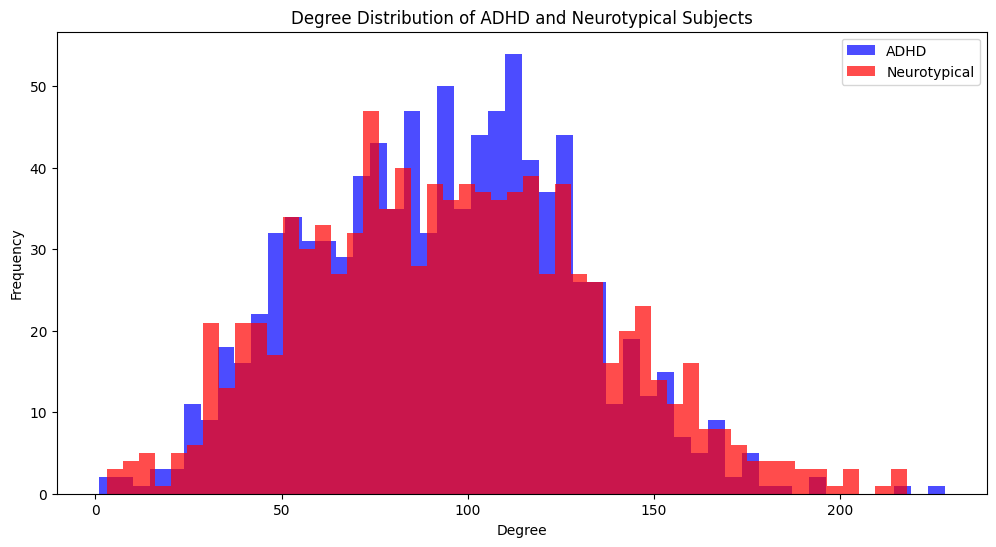

In [121]:
# plot the degree distribution for the ADHD and neurotypical subjects
# Load the sparsified matrices
sparsified_adhd_matrix = np.load("sparsified_adhd_matrix_10%.npy")
sparsified_neurotypical_matrix = np.load("sparsified_neurotypical_matrix_10%.npy")

# Create graphs from the matrices
G_adhd = nx.from_numpy_array(sparsified_adhd_matrix, create_using=nx.Graph)
G_neurotypical = nx.from_numpy_array(sparsified_neurotypical_matrix, create_using=nx.Graph)

# Calculate degree distributions
degree_sequence_adhd = [deg for node, deg in G_adhd.degree()]
degree_sequence_neurotypical = [deg for node, deg in G_neurotypical.degree()]

# Plot the degree distributions
plt.figure(figsize=(12, 6))
plt.hist(degree_sequence_adhd, bins=50, alpha=0.7, label="ADHD", color="b")
plt.hist(degree_sequence_neurotypical, bins=50, alpha=0.7, label="Neurotypical", color="r")
plt.title("Degree Distribution of ADHD and Neurotypical Subjects")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [122]:
# calculating the basic network statistics for the ADHD and neurotypical subjects
# Load the sparsified matrices
sparsified_adhd_matrix = np.load("sparsified_adhd_matrix_10%.npy")
sparsified_neurotypical_matrix = np.load("sparsified_neurotypical_matrix_10%.npy")

# Create graphs from the matrices
G_adhd = nx.from_numpy_array(sparsified_adhd_matrix, create_using=nx.Graph)
G_neurotypical = nx.from_numpy_array(sparsified_neurotypical_matrix, create_using=nx.Graph)

# Calculate basic network statistics
num_nodes_adhd = G_adhd.number_of_nodes()
num_edges_adhd = G_adhd.number_of_edges()
density_adhd = nx.density(G_adhd)

num_nodes_neurotypical = G_neurotypical.number_of_nodes()
num_edges_neurotypical = G_neurotypical.number_of_edges()
density_neurotypical = nx.density(G_neurotypical)

# Print results
print("ADHD Network Statistics:")
print(f"Number of nodes: {num_nodes_adhd}")
print(f"Number of edges: {num_edges_adhd}")
print(f"Density: {density_adhd:.4f}")
print()

print("Neurotypical Network Statistics:")
print(f"Number of nodes: {num_nodes_neurotypical}")
print(f"Number of edges: {num_edges_neurotypical}")
print(f"Density: {density_neurotypical:.4f}")

# Save the basic network statistics to a JSON file
network_statistics = {
    "ADHD": {
        "Number_of_Nodes": num_nodes_adhd,
        "Number_of_Edges": num_edges_adhd,
        "Density": density_adhd,
    },
    "Neurotypical": {
        "Number_of_Nodes": num_nodes_neurotypical,
        "Number_of_Edges": num_edges_neurotypical,
        "Density": density_neurotypical,
    },
}

with open("network_statistics.json", "w") as f:
    json.dump(network_statistics, f, indent=4)
print("Network statistics saved to network_statistics.json")

ADHD Network Statistics:
Number of nodes: 935
Number of edges: 43711
Density: 0.1001

Neurotypical Network Statistics:
Number of nodes: 950
Number of edges: 45600
Density: 0.1012
Network statistics saved to network_statistics.json


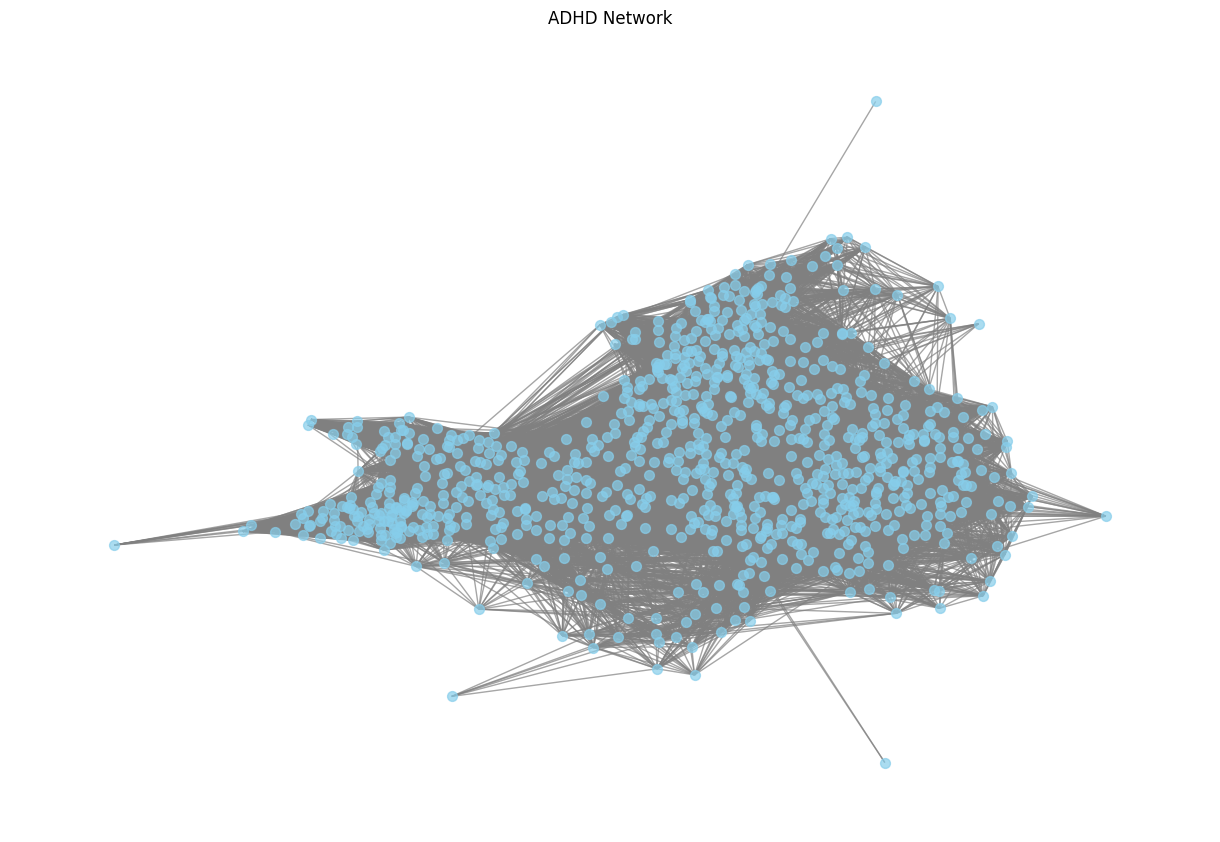

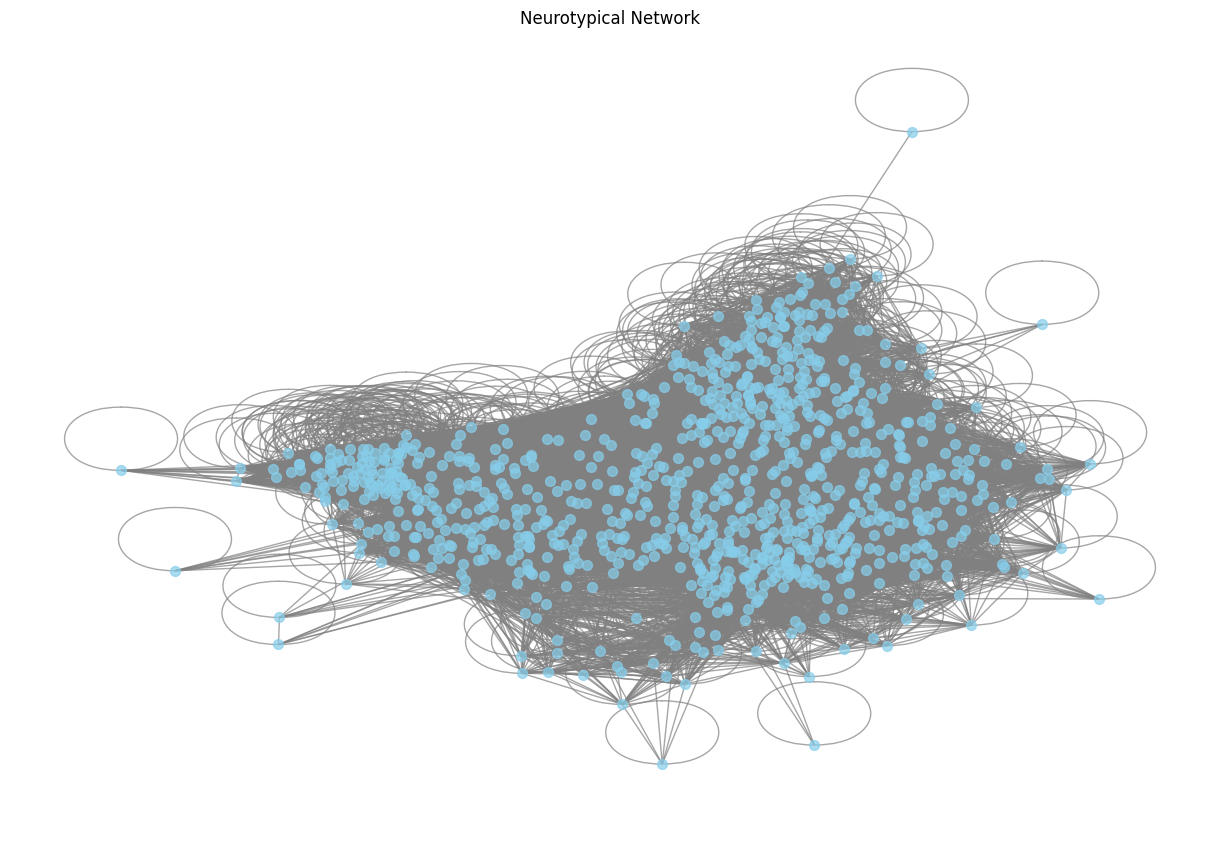

In [123]:
# Network Visualization
# Helper function to visualize the network
def visualize_network(G, title):
    """
    Visualize the network graph with a spring layout.
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_size=50, node_color="skyblue", edge_color="gray", alpha=0.7)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Visualize the ADHD network
visualize_network(G_adhd, title="ADHD Network")

# Visualize the Neurotypical network
visualize_network(G_neurotypical, title="Neurotypical Network")

### Null Models and Comparison (Observed vs Null Models)

The code below does the following:


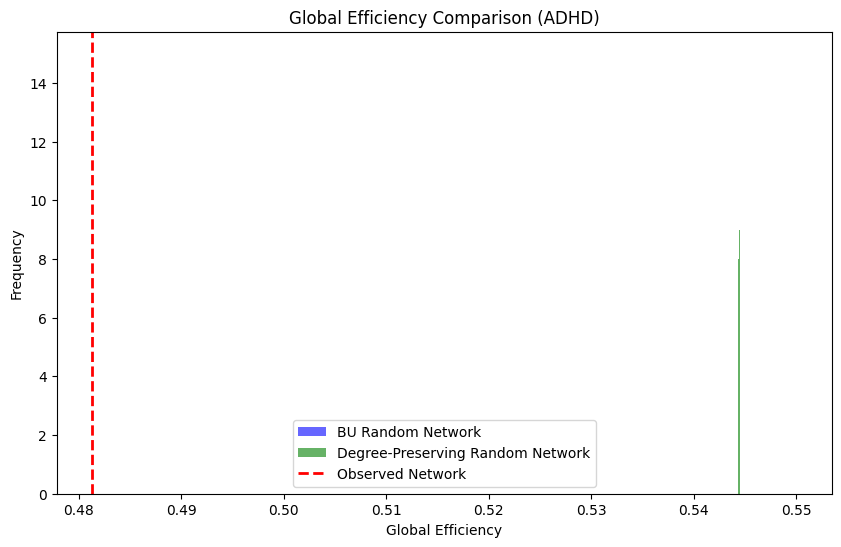

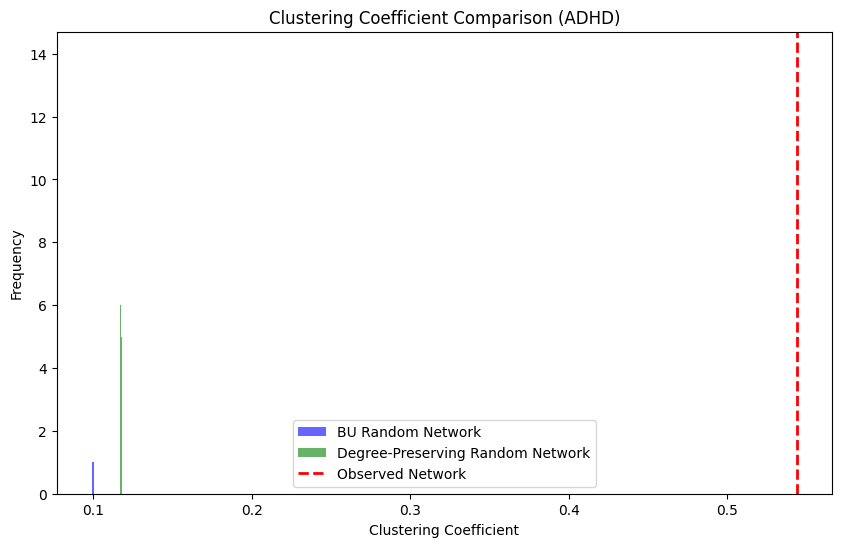

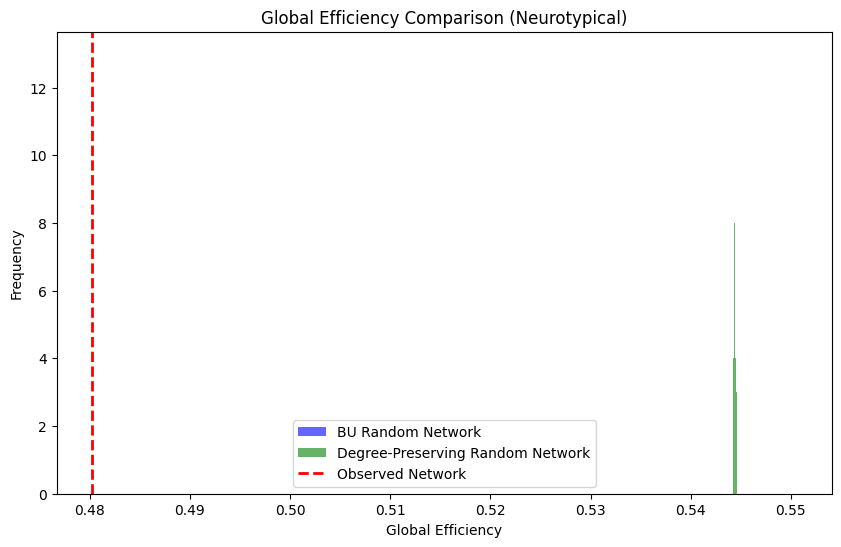

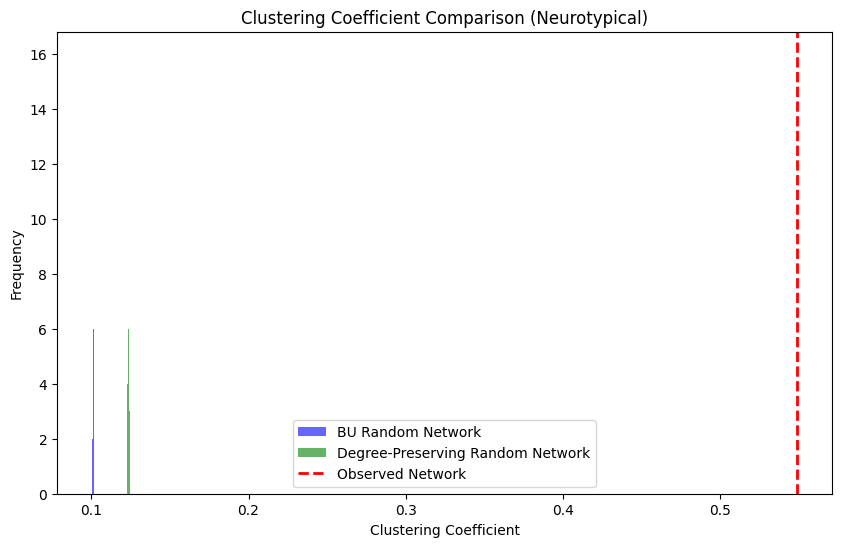

In [37]:
# Load the sparsified ADHD and Neurotypical matrices
adhd_matrix_sparse = np.load("sparsified_adhd_matrix_10%.npy")
neurotypical_matrix_sparse = np.load("sparsified_neurotypical_matrix_10%.npy")

# Helper function to calculate metrics
def calculate_metrics(graph):
    """
    Calculate global efficiency and clustering coefficient for a graph.
    """
    global_efficiency = nx.global_efficiency(graph)
    avg_clustering = nx.average_clustering(graph)
    return global_efficiency, avg_clustering

# Helper function to generate null models
def generate_null_models(graph, model_type="BU", num_iterations=100):
    """
    Generate null models (BU or degree-preserving random networks) and calculate metrics.
    """
    null_metrics = {
        "global_efficiency": [],
        "avg_clustering": []
    }

    for _ in range(num_iterations):
        if model_type == "BU":
            # Generate a random graph with the same number of nodes and edges
            random_graph = nx.gnm_random_graph(n=graph.number_of_nodes(), m=graph.number_of_edges())
        elif model_type == "DegreePreserving":
            # Generate a degree-preserving random graph using degree sequence
            random_graph = nx.configuration_model([d for _, d in graph.degree()])
            # Convert to a simple undirected graph
            random_graph = nx.Graph(random_graph)  # Remove parallel edges
            random_graph.remove_edges_from(nx.selfloop_edges(random_graph))  # Remove self-loops
        else:
            raise ValueError(f"Unknown null model type: {model_type}")

        # Calculate metrics for the null model
        global_eff, avg_clust = calculate_metrics(random_graph)
        null_metrics["global_efficiency"].append(global_eff)
        null_metrics["avg_clustering"].append(avg_clust)

    return null_metrics

# Create observed graphs
G_adhd = nx.from_numpy_array(adhd_matrix_sparse, create_using=nx.Graph)
G_neurotypical = nx.from_numpy_array(neurotypical_matrix_sparse, create_using=nx.Graph)

# Calculate observed metrics
adhd_metrics_obs = calculate_metrics(G_adhd)
neurotypical_metrics_obs = calculate_metrics(G_neurotypical)

# Generate null models and compare metrics
adhd_null_bu = generate_null_models(G_adhd, model_type="BU")
adhd_null_deg = generate_null_models(G_adhd, model_type="DegreePreserving")
neurotypical_null_bu = generate_null_models(G_neurotypical, model_type="BU")
neurotypical_null_deg = generate_null_models(G_neurotypical, model_type="DegreePreserving")

# Plot observed metrics vs. null models
def plot_null_comparison(observed, null_bu, null_deg, metric_name, group_name):
    """
    Plot observed metrics vs. null model distributions.
    """
    plt.figure(figsize=(10, 6))

    # Null model distributions
    plt.hist(null_bu, bins=20,  alpha=0.6, label="BU Random Network", color="blue")
    plt.hist(null_deg, bins=20, alpha=0.6, label="Degree-Preserving Random Network", color="green")

    # Observed metric
    plt.axvline(observed, color="red", linestyle="--", linewidth=2, label="Observed Network")

    plt.title(f"{metric_name} Comparison ({group_name})") # Title with group name - we can remove the group name if don't want this from here and from above in the function parameters
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# # Plot Global Efficiency Comparison
# plot_null_comparison(adhd_metrics_obs[0], adhd_null_bu["global_efficiency"], adhd_null_deg["global_efficiency"], "Global Efficiency")
# plot_null_comparison(neurotypical_metrics_obs[0], neurotypical_null_bu["global_efficiency"], neurotypical_null_deg["global_efficiency"], "Global Efficiency")

# # Plot Clustering Coefficient Comparison
# plot_null_comparison(adhd_metrics_obs[1], adhd_null_bu["avg_clustering"], adhd_null_deg["avg_clustering"], "Clustering Coefficient")
# plot_null_comparison(neurotypical_metrics_obs[1], neurotypical_null_bu["avg_clustering"], neurotypical_null_deg["avg_clustering"], "Clustering Coefficient")

# Plot for ADHD
plot_null_comparison(adhd_metrics_obs[0], adhd_null_bu["global_efficiency"], adhd_null_deg["global_efficiency"], "Global Efficiency", "ADHD")
plot_null_comparison(adhd_metrics_obs[1], adhd_null_bu["avg_clustering"], adhd_null_deg["avg_clustering"], "Clustering Coefficient", "ADHD")

# Plot for Neurotypical
plot_null_comparison(neurotypical_metrics_obs[0], neurotypical_null_bu["global_efficiency"], neurotypical_null_deg["global_efficiency"], "Global Efficiency", "Neurotypical")
plot_null_comparison(neurotypical_metrics_obs[1], neurotypical_null_bu["avg_clustering"], neurotypical_null_deg["avg_clustering"], "Clustering Coefficient", "Neurotypical")

#### Statistical Analysis

**Comparing Observed Metrics Against Null Models**

In [39]:
# Helper function to calculate z-scores and p-values
def calculate_statistical_significance(observed, null_distribution):
    """
    Calculate z-scores and p-values for observed metrics compared to a null distribution.
    """
    mean_null = np.mean(null_distribution)
    std_null = np.std(null_distribution)
    z_score = (observed - mean_null) / std_null
    p_value = 1 - norm.cdf(np.abs(z_score))  # Two-tailed test
    return z_score, p_value

# ADHD Network
adhd_global_eff_z, adhd_global_eff_p = calculate_statistical_significance(
    adhd_metrics_obs[0], adhd_null_bu["global_efficiency"]
)
adhd_clustering_z, adhd_clustering_p = calculate_statistical_significance(
    adhd_metrics_obs[1], adhd_null_bu["avg_clustering"]
)

# Neurotypical Network
neurotypical_global_eff_z, neurotypical_global_eff_p = calculate_statistical_significance(
    neurotypical_metrics_obs[0], neurotypical_null_bu["global_efficiency"]
)
neurotypical_clustering_z, neurotypical_clustering_p = calculate_statistical_significance(
    neurotypical_metrics_obs[1], neurotypical_null_bu["avg_clustering"]
)

# Print results
print("ADHD Global Efficiency Z-Score:", adhd_global_eff_z, "P-Value:", adhd_global_eff_p)
print("ADHD Clustering Coefficient Z-Score:", adhd_clustering_z, "P-Value:", adhd_clustering_p)
print("Neurotypical Global Efficiency Z-Score:", neurotypical_global_eff_z, "P-Value:", neurotypical_global_eff_p)
print("Neurotypical Clustering Coefficient Z-Score:", neurotypical_clustering_z, "P-Value:", neurotypical_clustering_p)

ADHD Global Efficiency Z-Score: -32229.146161157067 P-Value: 0.0
ADHD Clustering Coefficient Z-Score: 1477.474836662333 P-Value: 0.0
Neurotypical Global Efficiency Z-Score: -38871.53922772976 P-Value: 0.0
Neurotypical Clustering Coefficient Z-Score: 1998.6029759876335 P-Value: 0.0


**Comparing ADHD and Neurotypical Networks**

In [41]:
# two sample t-test
# Combine global efficiency and clustering coefficient distributions
adhd_global_eff_distribution = adhd_null_bu["global_efficiency"]
neurotypical_global_eff_distribution = neurotypical_null_bu["global_efficiency"]

adhd_clustering_distribution = adhd_null_bu["avg_clustering"]
neurotypical_clustering_distribution = neurotypical_null_bu["avg_clustering"]

# Perform t-tests
t_global_eff, p_global_eff = ttest_ind(
    adhd_global_eff_distribution, neurotypical_global_eff_distribution, equal_var=False
)
t_clustering, p_clustering = ttest_ind(
    adhd_clustering_distribution, neurotypical_clustering_distribution, equal_var=False
)

# Print results
print("T-Test for Global Efficiency: t =", t_global_eff, ", p =", p_global_eff)
print("T-Test for Clustering Coefficient: t =", t_clustering, ", p =", p_clustering)


T-Test for Global Efficiency: t = -1887.3157778516004 , p = 0.0
T-Test for Clustering Coefficient: t = -27.224849761219645 , p = 2.7454009953844516e-66


**Interpretation**

**Q2 - Are there specific hub regions in the functional brain networks of ADHD patients that are more susceptible to altered connectivity compared to controls, and how do these hubs relate to ADHD symptom severity?**

In [ ]:
# # Paths
# adhd_matrices_path = "."  # Replace with the path to ADHD adjacency matrices
# neurotypical_matrices_path = "."  # Path to neurotypical adjacency matrices
# phenotype_file = "combined_phenotype_file.csv"  # Path to phenotype data

# # Load phenotype data
# phenotype_data = pd.read_csv(phenotype_file)
# phenotype_data["ScanDir ID"] = phenotype_data["ScanDir ID"].astype(str)

# # Function to calculate centrality measures
# def calculate_centrality_measures(matrix):
#     """
#     Calculate centrality measures for a given adjacency matrix.
#     """
#     G = nx.from_numpy_array(matrix)
#     degree_centrality = nx.degree_centrality(G)
#     betweenness_centrality = nx.betweenness_centrality(G)
#     eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
#     return {
#         "ROI": list(degree_centrality.keys()),
#         "Degree_Centrality": list(degree_centrality.values()),
#         "Betweenness_Centrality": list(betweenness_centrality.values()),
#         "Eigenvector_Centrality": list(eigenvector_centrality.values()),
#     }

# # Initialize lists to store metrics for ADHD and neurotypical subjects
# adhd_metrics = []
# neurotypical_metrics = []

# # Process ADHD matrices
# for file_name in os.listdir(adhd_matrices_path):
#     if file_name.endswith(".npy"):
#         subject_id = file_name.split("_")[0]  # Extract ScanDir ID from file name
#         matrix = np.load(os.path.join(adhd_matrices_path, file_name))  # Load adjacency matrix
#         centrality = calculate_centrality_measures(matrix)  # Calculate centrality measures
#         centrality["ScanDir ID"] = subject_id  # Add subject ID
#         adhd_metrics.append(pd.DataFrame(centrality))

# # Process neurotypical matrices
# for file_name in os.listdir(neurotypical_matrices_path):
#     if file_name.endswith(".npy"):
#         subject_id = file_name.split("_")[1].split(".")[0]  # Extract ScanDir ID from file name
#         matrix = np.load(os.path.join(neurotypical_matrices_path, file_name))  # Load adjacency matrix
#         centrality = calculate_centrality_measures(matrix)  # Calculate centrality measures
#         centrality["ScanDir ID"] = subject_id  # Add subject ID
#         neurotypical_metrics.append(pd.DataFrame(centrality))

# # Combine results into dataframes
# adhd_metrics_df = pd.concat(adhd_metrics, ignore_index=True)
# neurotypical_metrics_df = pd.concat(neurotypical_metrics, ignore_index=True)

# # Calculate group-level averages
# adhd_group_avg = adhd_metrics_df.groupby("ROI").mean().reset_index()
# neurotypical_group_avg = neurotypical_metrics_df.groupby("ROI").mean().reset_index()

# # Calculate centrality differences
# centrality_diff = adhd_group_avg.set_index("ROI").subtract(
#     neurotypical_group_avg.set_index("ROI"), fill_value=0
# ).reset_index()

# # Identify ROIs with the largest differences
# top_diff_rois = centrality_diff.nlargest(10, "Degree_Centrality")
# print("\nROIs with largest centrality differences:")
# print(top_diff_rois)

# # Visualize the top centrality differences
# plt.figure(figsize=(10, 6))
# plt.bar(top_diff_rois["ROI"], top_diff_rois["Degree_Centrality"], color="purple", alpha=0.7)
# plt.xlabel("ROI")
# plt.ylabel("Degree Centrality Difference")
# plt.title("Top Hub ROIs with Centrality Differences: ADHD vs Neurotypical")
# plt.show()

# # Save results
# centrality_diff.to_csv("centrality_differences.csv", index=False)
# print("\nCentrality differences saved to 'centrality_differences.csv'.")

# # Analyze top hubs for ADHD and neurotypical separately
# top_adhd_hubs = adhd_group_avg.nlargest(10, "Degree_Centrality")
# top_neurotypical_hubs = neurotypical_group_avg.nlargest(10, "Degree_Centrality")

# print("\nTop Hub ROIs for ADHD based on Degree Centrality:")
# print(top_adhd_hubs)

# print("\nTop Hub ROIs for Neurotypical based on Degree Centrality:")
# print(top_neurotypical_hubs)

# # Visualize top hubs for both groups
# plt.figure(figsize=(12, 6))
# plt.bar(top_adhd_hubs["ROI"], top_adhd_hubs["Degree_Centrality"], color="blue", alpha=0.7, label="ADHD")
# plt.bar(top_neurotypical_hubs["ROI"], top_neurotypical_hubs["Degree_Centrality"], color="orange", alpha=0.7, label="Neurotypical")
# plt.xlabel("ROI")
# plt.ylabel("Degree Centrality")
# plt.title("Top Hub ROIs: ADHD vs Neurotypical")
# plt.legend()
# plt.show()


In [84]:
# Paths
adhd_matrices_path = "."  # Replace with the path to ADHD adjacency matrices
neurotypical_matrices_path = "."  # Replace with the path to neurotypical adjacency matrices

# ADHD filenames
valid_subject_files_adhd = [
    '2228148_matrix.npy', '4055710_matrix.npy', '3691107_matrix.npy', '4073815_matrix.npy', '3827352_matrix.npy',
    '5993008_matrix.npy', '3205761_matrix.npy', '4091983_matrix.npy', '1186237_matrix.npy', '7253183_matrix.npy',
    '2950754_matrix.npy', '1282248_matrix.npy', '3856956_matrix.npy', '3976121_matrix.npy', '2174595_matrix.npy',
    '2737106_matrix.npy', '4053388_matrix.npy', '4221029_matrix.npy', '2884672_matrix.npy', '1791543_matrix.npy',
    '3910672_matrix.npy', '1561488_matrix.npy', '8278680_matrix.npy', '2207418_matrix.npy', '2367157_matrix.npy',
    '4095748_matrix.npy', '2529026_matrix.npy', '4006710_matrix.npy', '1628610_matrix.npy', '5150328_matrix.npy',
    '6383713_matrix.npy', '1947991_matrix.npy', '1356553_matrix.npy', '2940712_matrix.npy', '3390312_matrix.npy',
    '2780647_matrix.npy', '3803759_matrix.npy', '4225073_matrix.npy', '5193577_matrix.npy', '2031422_matrix.npy',
    '3446674_matrix.npy', '3672300_matrix.npy', '2919220_matrix.npy', '3561920_matrix.npy', '1094669_matrix.npy',
    '7689953_matrix.npy', '2141250_matrix.npy', '1771270_matrix.npy', '6500128_matrix.npy', '4028266_matrix.npy',
    '2697768_matrix.npy', '1399863_matrix.npy', '2276801_matrix.npy', '1240299_matrix.npy', '4334113_matrix.npy',
    '1809715_matrix.npy', '1341865_matrix.npy', '2907951_matrix.npy', '3194757_matrix.npy', '2196753_matrix.npy',
    '9002207_matrix.npy', '1133221_matrix.npy', '1643780_matrix.npy', '7390867_matrix.npy', '2897046_matrix.npy',
    '2984158_matrix.npy', '2524687_matrix.npy', '4241194_matrix.npy', '2601519_matrix.npy', '2910270_matrix.npy',
    '4075719_matrix.npy', '3712305_matrix.npy', '3983607_matrix.npy', '9210521_matrix.npy'
]

# Neurotypical filenames
valid_subject_files_neurotypical = [
    'neurotypical_4048810_matrix.npy', 'neurotypical_2268253_matrix.npy', 'neurotypical_2538839_matrix.npy',
    'neurotypical_2240562_matrix.npy', 'neurotypical_2249443_matrix.npy', 'neurotypical_2266806_matrix.npy',
    'neurotypical_7135128_matrix.npy', 'neurotypical_2498847_matrix.npy', 'neurotypical_3732101_matrix.npy',
    'neurotypical_9887336_matrix.npy', 'neurotypical_3157406_matrix.npy', 'neurotypical_2703336_matrix.npy',
    'neurotypical_1302449_matrix.npy', 'neurotypical_1469171_matrix.npy', 'neurotypical_3308331_matrix.npy',
    'neurotypical_2310449_matrix.npy', 'neurotypical_1912810_matrix.npy', 'neurotypical_4921428_matrix.npy',
    'neurotypical_3930512_matrix.npy', 'neurotypical_1875013_matrix.npy', 'neurotypical_2408774_matrix.npy',
    'neurotypical_9221927_matrix.npy', 'neurotypical_4383707_matrix.npy', 'neurotypical_2833684_matrix.npy',
    'neurotypical_1113498_matrix.npy', 'neurotypical_2081754_matrix.npy', 'neurotypical_4475709_matrix.npy',
    'neurotypical_5575344_matrix.npy', 'neurotypical_1860323_matrix.npy', 'neurotypical_2208591_matrix.npy',
    'neurotypical_2559537_matrix.npy', 'neurotypical_2427408_matrix.npy', 'neurotypical_5669389_matrix.npy',
    'neurotypical_3494778_matrix.npy', 'neurotypical_3277313_matrix.npy', 'neurotypical_8328877_matrix.npy',
    'neurotypical_1056121_matrix.npy', 'neurotypical_6187322_matrix.npy', 'neurotypical_3385520_matrix.npy',
    'neurotypical_3212536_matrix.npy', 'neurotypical_1794770_matrix.npy', 'neurotypical_9890726_matrix.npy',
    'neurotypical_1408093_matrix.npy', 'neurotypical_3239413_matrix.npy', 'neurotypical_3473830_matrix.npy',
    'neurotypical_3233028_matrix.npy', 'neurotypical_1494102_matrix.npy', 'neurotypical_1875711_matrix.npy',
    'neurotypical_1662160_matrix.npy', 'neurotypical_1132854_matrix.npy', 'neurotypical_2377207_matrix.npy',
    'neurotypical_6477085_matrix.npy', 'neurotypical_2106109_matrix.npy', 'neurotypical_3707771_matrix.npy',
    'neurotypical_8191384_matrix.npy', 'neurotypical_8838009_matrix.npy', 'neurotypical_1805037_matrix.npy',
    'neurotypical_1258069_matrix.npy', 'neurotypical_1404738_matrix.npy', 'neurotypical_3004580_matrix.npy',
    'neurotypical_3889095_matrix.npy', 'neurotypical_1916266_matrix.npy', 'neurotypical_1686092_matrix.npy',
    'neurotypical_3248920_matrix.npy', 'neurotypical_3306863_matrix.npy', 'neurotypical_3994098_matrix.npy',
    'neurotypical_2107404_matrix.npy', 'neurotypical_1562298_matrix.npy', 'neurotypical_2296326_matrix.npy',
    'neurotypical_3809753_matrix.npy', 'neurotypical_1177160_matrix.npy', 'neurotypical_3993793_matrix.npy',
    'neurotypical_3086074_matrix.npy', 'neurotypical_3610134_matrix.npy', 'neurotypical_7407032_matrix.npy',
    'neurotypical_3269608_matrix.npy', 'neurotypical_3672854_matrix.npy', 'neurotypical_2123983_matrix.npy',
    'neurotypical_3554582_matrix.npy', 'neurotypical_1411536_matrix.npy', 'neurotypical_1689948_matrix.npy',
    'neurotypical_4053836_matrix.npy', 'neurotypical_3593327_matrix.npy', 'neurotypical_9093997_matrix.npy',
    'neurotypical_1139030_matrix.npy', 'neurotypical_4265987_matrix.npy', 'neurotypical_1050345_matrix.npy',
    'neurotypical_1050975_matrix.npy', 'neurotypical_1117299_matrix.npy', 'neurotypical_2659769_matrix.npy',
    'neurotypical_3624598_matrix.npy', 'neurotypical_2714224_matrix.npy', 'neurotypical_1093743_matrix.npy',
    'neurotypical_3262042_matrix.npy', 'neurotypical_7011503_matrix.npy', 'neurotypical_9640133_matrix.npy',
    'neurotypical_4136226_matrix.npy', 'neurotypical_4256491_matrix.npy', 'neurotypical_9578631_matrix.npy',
    'neurotypical_3739175_matrix.npy', 'neurotypical_2140063_matrix.npy', 'neurotypical_3224401_matrix.npy',
    'neurotypical_3562883_matrix.npy', 'neurotypical_7994085_matrix.npy', 'neurotypical_3655623_matrix.npy',
    'neurotypical_2535087_matrix.npy', 'neurotypical_1068505_matrix.npy', 'neurotypical_1879542_matrix.npy',
    'neurotypical_3587000_matrix.npy', 'neurotypical_1391181_matrix.npy', 'neurotypical_7093319_matrix.npy',
    'neurotypical_2033178_matrix.npy', 'neurotypical_3967265_matrix.npy', 'neurotypical_9783279_matrix.npy'
]


# Function to calculate centrality measures
def calculate_centrality_measures(matrix):
    """
    Calculate centrality measures for a given adjacency matrix.
    """
    G = nx.from_numpy_array(matrix)
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    return {
        "ROI": list(degree_centrality.keys()),
        "Degree_Centrality": list(degree_centrality.values()),
        "Betweenness_Centrality": list(betweenness_centrality.values()),
        "Eigenvector_Centrality": list(eigenvector_centrality.values()),
    }


In [85]:
# Process ADHD matrices
adhd_metrics = []
for file_name in valid_subject_files_adhd:
    file_path = os.path.join(adhd_matrices_path, file_name)
    if os.path.exists(file_path):
        matrix = np.load(file_path)
        centrality = calculate_centrality_measures(matrix)
        centrality["Subject_ID"] = file_name.split("_")[0]
        adhd_metrics.append(pd.DataFrame(centrality))



# Combine results into dataframes and save
adhd_metrics_df = pd.concat(adhd_metrics, ignore_index=True)


adhd_metrics_df.to_csv("adhd_metrics.csv", index=False)


print("ADHD and Neurotypical metrics saved as 'adhd_metrics.csv'.")

ADHD and Neurotypical metrics saved as 'adhd_metrics.csv'.


In [86]:
# Process neurotypical matrices
neurotypical_metrics = []
for file_name in valid_subject_files_neurotypical:
    file_path = os.path.join(neurotypical_matrices_path, file_name)
    if os.path.exists(file_path):
        matrix = np.load(file_path)
        centrality = calculate_centrality_measures(matrix)
        centrality["Subject_ID"] = file_name.split("_")[1].split(".")[0]
        neurotypical_metrics.append(pd.DataFrame(centrality))

# Combine results into dataframes
neurotypical_metrics_df = pd.concat(neurotypical_metrics, ignore_index=True)

neurotypical_metrics_df.to_csv("neurotypical_metrics.csv", index=False)

print("ADHD and Neurotypical metrics saved as 'neurotypical_metrics.csv'.")

ADHD and Neurotypical metrics saved as 'neurotypical_metrics.csv'.


In [87]:
# Load processed metrics data
adhd_metrics_df = pd.read_csv("adhd_metrics.csv")
neurotypical_metrics_df = pd.read_csv("neurotypical_metrics.csv")

# Ensure numeric columns
numeric_cols = ["Degree_Centrality", "Betweenness_Centrality", "Eigenvector_Centrality"]
adhd_metrics_df[numeric_cols] = adhd_metrics_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
neurotypical_metrics_df[numeric_cols] = neurotypical_metrics_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate group-level averages
adhd_group_avg = adhd_metrics_df.groupby("ROI")[numeric_cols].mean().reset_index()
neurotypical_group_avg = neurotypical_metrics_df.groupby("ROI")[numeric_cols].mean().reset_index()

# Calculate centrality differences
centrality_diff = adhd_group_avg.set_index("ROI").subtract(
    neurotypical_group_avg.set_index("ROI"), fill_value=0
).reset_index()

# Identify ROIs with the largest differences
top_diff_rois = centrality_diff.nlargest(10, "Degree_Centrality")
print("\nTop ROIs with largest centrality differences:")
print(top_diff_rois)


Top ROIs with largest centrality differences:
     ROI  Degree_Centrality  Betweenness_Centrality  Eigenvector_Centrality
18    18           0.061883                0.000095                0.005768
86    86           0.058472                0.000171                0.005104
703  703           0.052530                0.000144                0.004632
205  205           0.048931                0.000110                0.003589
156  156           0.048561                0.000103                0.004180
212  212           0.048526                0.000111                0.004376
832  832           0.044130                0.000084                0.003678
669  669           0.044095                0.000152                0.003329
155  155           0.043610               -0.000010                0.004568
573  573           0.042869                0.000041                0.004135


In [89]:
# Top ROIs (hubs) for ADHD
top_hubs_adhd = adhd_group_avg.nlargest(10, "Degree_Centrality")
print("\nTop Hub ROIs for ADHD based on Degree Centrality:")
print(top_hubs_adhd)

# Top ROIs (hubs) for Neurotypical
top_hubs_neurotypical = neurotypical_group_avg.nlargest(10, "Degree_Centrality")
print("\nTop Hub ROIs for Neurotypical based on Degree Centrality:")
print(top_hubs_neurotypical)



Top Hub ROIs for ADHD based on Degree Centrality:
     ROI  Degree_Centrality  Betweenness_Centrality  Eigenvector_Centrality
718  718           0.539906                0.001104                0.041121
906  906           0.536915                0.001132                0.041025
911  911           0.531572                0.001072                0.040940
905  905           0.523042                0.001014                0.040063
947  947           0.519413                0.001038                0.039808
904  904           0.514707                0.001028                0.039248
326  326           0.502479                0.000902                0.038204
702  702           0.501831                0.000916                0.038361
907  907           0.500748                0.000979                0.038458
723  723           0.500287                0.000901                0.038563

Top Hub ROIs for Neurotypical based on Degree Centrality:
     ROI  Degree_Centrality  Betweenness_Centrality  E

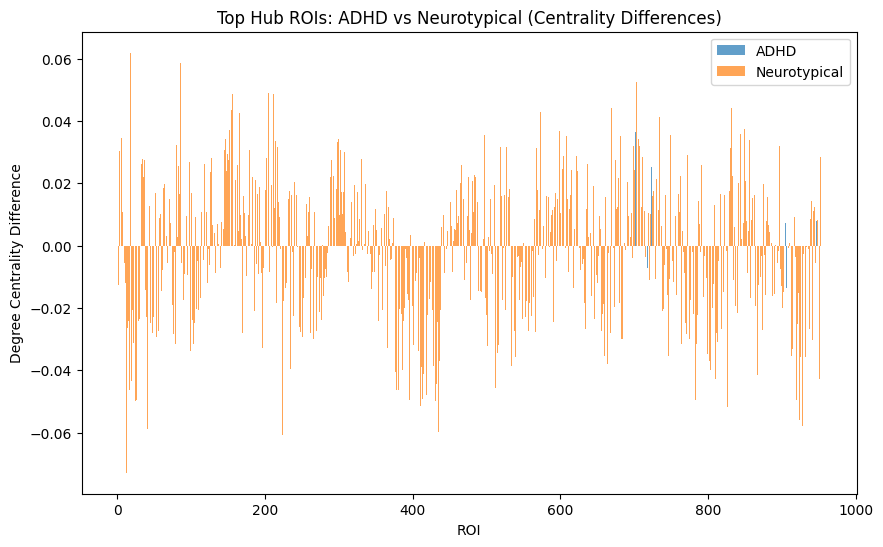

In [90]:
# Merge ADHD and Neurotypical averages for clarity
centrality_diff["Group"] = centrality_diff["ROI"].apply(
    lambda roi: "ADHD" if roi in top_hubs_adhd["ROI"].values else "Neurotypical"
)

# Visualize the centrality differences with group distinction
plt.figure(figsize=(10, 6))
for group in ["ADHD", "Neurotypical"]:
    subset = centrality_diff[centrality_diff["Group"] == group]
    plt.bar(subset["ROI"], subset["Degree_Centrality"], label=group, alpha=0.7)

plt.xlabel("ROI")
plt.ylabel("Degree Centrality Difference")
plt.title("Top Hub ROIs: ADHD vs Neurotypical (Centrality Differences)")
plt.legend()
plt.show()


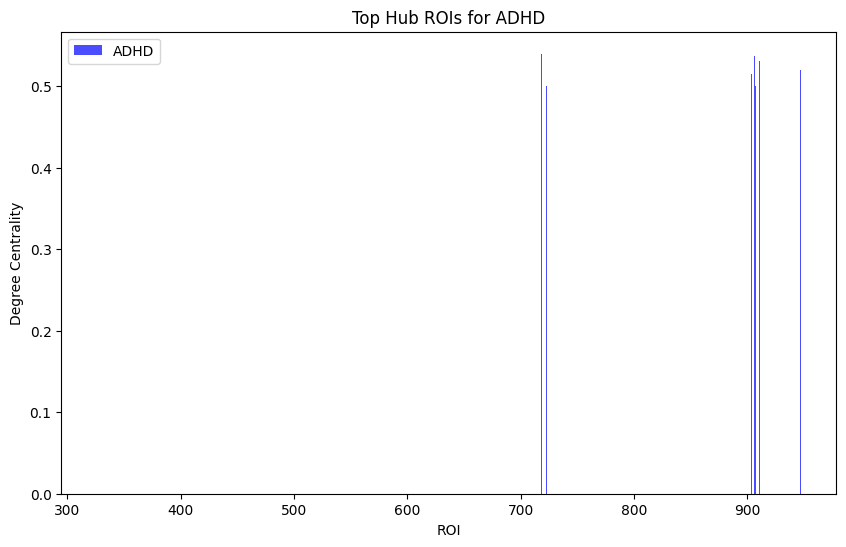

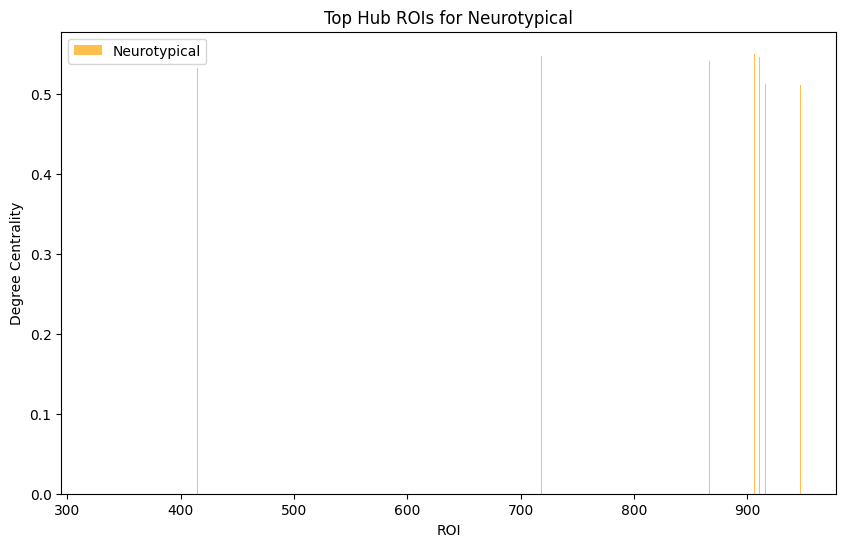

In [91]:
# Plot top hubs for ADHD
plt.figure(figsize=(10, 6))
plt.bar(top_hubs_adhd["ROI"], top_hubs_adhd["Degree_Centrality"], color="blue", alpha=0.7, label="ADHD")
plt.xlabel("ROI")
plt.ylabel("Degree Centrality")
plt.title("Top Hub ROIs for ADHD")
plt.legend()
plt.show()

# Plot top hubs for Neurotypical
plt.figure(figsize=(10, 6))
plt.bar(top_hubs_neurotypical["ROI"], top_hubs_neurotypical["Degree_Centrality"], color="orange", alpha=0.7, label="Neurotypical")
plt.xlabel("ROI")
plt.ylabel("Degree Centrality")
plt.title("Top Hub ROIs for Neurotypical")
plt.legend()
plt.show()


**Analysis with Phenotype Data**

1. Mapping phenotype data to centrality data

In [101]:
# Load processed metrics data
adhd_metrics_df = pd.read_csv("adhd_metrics.csv")
neurotypical_metrics_df = pd.read_csv("neurotypical_metrics.csv")

In [102]:
# looking at the columns of both dataframes
print(adhd_metrics_df.columns)
print(neurotypical_metrics_df.columns)

Index(['ROI', 'Degree_Centrality', 'Betweenness_Centrality',
       'Eigenvector_Centrality', 'Subject_ID'],
      dtype='object')
Index(['ROI', 'Degree_Centrality', 'Betweenness_Centrality',
       'Eigenvector_Centrality', 'Subject_ID'],
      dtype='object')


In [103]:
# Load phenotype data
phenotype_file = "combined_phenotype_file.csv"
phenotype_data = pd.read_csv(phenotype_file)

# looking at the columns of the phenotype data
print(phenotype_data.columns)

Index(['ScanDir ID', 'Site', 'Gender', 'Age', 'Handedness', 'DX',
       'Secondary Dx ', 'ADHD Measure', 'ADHD Index', 'Inattentive',
       'Hyper/Impulsive', 'IQ Measure', 'Verbal IQ', 'Performance IQ',
       'Full2 IQ', 'Full4 IQ', 'Med Status', 'QC_Rest_1', 'QC_Rest_2',
       'QC_Rest_3', 'QC_Rest_4', 'QC_Anatomical_1', 'QC_Anatomical_2'],
      dtype='object')


In [104]:
# rename the column to match the subject ID
phenotype_data.rename(columns={"ScanDir ID": "Subject_ID"}, inplace=True)


In [105]:
# looking at the columns of the phenotype data
print(phenotype_data.columns)

Index(['Subject_ID', 'Site', 'Gender', 'Age', 'Handedness', 'DX',
       'Secondary Dx ', 'ADHD Measure', 'ADHD Index', 'Inattentive',
       'Hyper/Impulsive', 'IQ Measure', 'Verbal IQ', 'Performance IQ',
       'Full2 IQ', 'Full4 IQ', 'Med Status', 'QC_Rest_1', 'QC_Rest_2',
       'QC_Rest_3', 'QC_Rest_4', 'QC_Anatomical_1', 'QC_Anatomical_2'],
      dtype='object')


In [106]:
adhd_metrics_df["Subject_ID"] = adhd_metrics_df["Subject_ID"].astype(str)
neurotypical_metrics_df["Subject_ID"] = neurotypical_metrics_df["Subject_ID"].astype(str)
phenotype_data["Subject_ID"] = phenotype_data["Subject_ID"].astype(str)

In [107]:
# Merge with phenotype data
adhd_phenotype_merged = adhd_metrics_df.merge(phenotype_data, on="Subject_ID", how="inner")
neurotypical_phenotype_merged = neurotypical_metrics_df.merge(phenotype_data, on="Subject_ID", how="inner")

print("ADHD merged data shape:", adhd_phenotype_merged.shape)
print("Neurotypical merged data shape:", neurotypical_phenotype_merged.shape)

ADHD merged data shape: (70502, 27)
Neurotypical merged data shape: (108741, 27)


2. Correlation Analysis

In [ ]:
# Correlation analysis for ADHD
symptom_columns = ["ADHD Index", "Inattentive", "Hyper/Impulsive"]
for symptom in symptom_columns:
    if symptom in adhd_phenotype_merged.columns:
        correlation_results = {}
        for centrality in ["Degree_Centrality", "Betweenness_Centrality", "Eigenvector_Centrality"]:
            corr = adhd_phenotype_merged[centrality].corr(adhd_phenotype_merged[symptom])
            correlation_results[centrality] = corr
        print(f"\nCorrelation of centrality metrics with {symptom} for ADHD:")
        print(correlation_results)

# Correlation analysis for Neurotypical (optional)
for symptom in symptom_columns:
    if symptom in neurotypical_phenotype_merged.columns:
        correlation_results = {}
        for centrality in ["Degree_Centrality", "Betweenness_Centrality", "Eigenvector_Centrality"]:
            corr = neurotypical_phenotype_merged[centrality].corr(neurotypical_phenotype_merged[symptom])
            correlation_results[centrality] = corr  
        print(f"\nCorrelation of centrality metrics with {symptom} for Neurotypical:")
        print(correlation_results)



Correlation of centrality metrics with ADHD Index for ADHD:
{'Degree_Centrality': np.float64(5.532556180102326e-07), 'Betweenness_Centrality': np.float64(0.0015049129517673515), 'Eigenvector_Centrality': np.float64(0.0011054948297747088)}

Correlation of centrality metrics with Inattentive for ADHD:
{'Degree_Centrality': np.float64(5.498339397983938e-07), 'Betweenness_Centrality': np.float64(0.0015096013571621433), 'Eigenvector_Centrality': np.float64(0.000987486143049328)}

Correlation of centrality metrics with Hyper/Impulsive for ADHD:
{'Degree_Centrality': np.float64(5.488728611773222e-07), 'Betweenness_Centrality': np.float64(0.001521331585966729), 'Eigenvector_Centrality': np.float64(0.0010842408799761664)}

Correlation of centrality metrics with ADHD Index for Neurotypical:
{'Degree_Centrality': np.float64(-4.5073457870367876e-07), 'Betweenness_Centrality': np.float64(0.0021031964846499863), 'Eigenvector_Centrality': np.float64(0.008847179660803667)}

Correlation of centrality 

3. Compare ADHD and Neurotypical Groups
 - Identify and compare hubs

In [109]:
# Identify top hubs for ADHD and Neurotypical groups
adhd_hubs = set(adhd_metrics_df.groupby("ROI")["Degree_Centrality"].mean().nlargest(10).index)
neurotypical_hubs = set(neurotypical_metrics_df.groupby("ROI")["Degree_Centrality"].mean().nlargest(10).index)

# Find shared and unique hubs
shared_hubs = adhd_hubs & neurotypical_hubs
unique_adhd_hubs = adhd_hubs - neurotypical_hubs
unique_neurotypical_hubs = neurotypical_hubs - adhd_hubs

print("Shared Hubs:", shared_hubs)
print("Unique ADHD Hubs:", unique_adhd_hubs)
print("Unique Neurotypical Hubs:", unique_neurotypical_hubs)

Shared Hubs: {326, 905, 906, 718, 911, 947}
Unique ADHD Hubs: {904, 907, 702, 723}
Unique Neurotypical Hubs: {920, 867, 916, 415}


 - Statistical Comparison

In [110]:
# Perform t-test for centrality differences in shared hubs
for centrality in ["Degree_Centrality", "Betweenness_Centrality", "Eigenvector_Centrality"]:
    adhd_shared = adhd_metrics_df[adhd_metrics_df["ROI"].isin(shared_hubs)][centrality]
    neurotypical_shared = neurotypical_metrics_df[neurotypical_metrics_df["ROI"].isin(shared_hubs)][centrality]
    
    t_stat, p_value = ttest_ind(adhd_shared, neurotypical_shared, nan_policy="omit")
    print(f"T-test for {centrality} in shared hubs: t-stat={t_stat:.4f}, p-value={p_value:.4f}")

T-test for Degree_Centrality in shared hubs: t-stat=-0.8301, p-value=0.4067
T-test for Betweenness_Centrality in shared hubs: t-stat=-2.0608, p-value=0.0396
T-test for Eigenvector_Centrality in shared hubs: t-stat=0.0452, p-value=0.9639


**Discussion - Are there specific hub regions in the functional brain networks of ADHD patients that are more susceptible to altered connectivity compared to controls?**

Based on the analysis, we identified common and unique hub between ADHD patients and neurotypical controls. These hubs were determined using centrality metrics derived from functional brain networks.

Common hub regions:

- The common hubs between ADHD and neurotypical groups were ROI 326, ROI 905, ROI 906, ROI 718, ROI 911, and ROI 947.
- These regions represent areas of overlap where connectivity patterns are similar in the brains of ADHD patients and neurotypical controls.

Unique hub regions:

- ADHD-specific hubs were identified as ROI 904, ROI 907, ROI 702, and ROI 723. These regions are unique to the ADHD group and suggest altered connectivity patterns that may underlie ADHD-specific brain function.
- Neurotypical nodes were identified as ROI 920, ROI 867, ROI 916 and ROI 415, indicating regions that are particularly active in control subjects but not in ADHD patients.

Susceptibility to altered connectivity:

- The results suggest that certain brain regions (unique nodes) are more susceptible to altered connectivity in ADHD patients compared to controls. These ADHD-specific hubs may reflect neural pathways or regions involved in ADHD-related dysfunction, such as attention regulation, impulse control and executive functions.
- Shared nodes also exhibit differences in connectivity metrics, as shown by the significant difference in betweenness centrality (p = 0.0396). This suggests that even in overlapping regions, the role of these nodes in mediating connectivity between different parts of the network differs between ADHD and neurotypical groups.

Interpretation

The results show that ADHD-specific hubs are significantly altered, highlighting their susceptibility to changes in connectivity patterns. These hubs may represent potential targets for further investigation of ADHD-related brain dysfunction and treatment strategies. In addition, the significant difference in betweenness centrality within shared hubs suggests that certain regions are common to both groups but differ in their functional significance, further emphasizing the altered network dynamics in ADHD.

**Discussion - How do these hubs related to the severity of ADHD symptoms?**

To examine the relationship between hub regions and ADHD symptom severity, we analyzed the correlations between centrality metrics (degree centrality, betweenness centrality, and eigenvector centrality) and symptom scores for the ADHD Index, Inattentive, and Hyper/Impulsive subtypes. 

The following key findings were observed:

1. Correlation results for ADHD symptoms:
    - ADHD Index:
        - Degree Centrality: Weak positive correlation (r≈5.53×10−7)
        - Betweenness centrality: Low positive correlation (r≈0.0015)
        - Eigenvector centrality: Low positive correlation (r≈0.0011)

    - Inattentive:
        - Degree centrality: Weak positive correlation (r≈5.50×10−7)
        - Betweenness centrality: Low positive correlation (r≈0.0015)
        - Eigenvector centrality: Low positive correlation (r≈0.00099)
    - Hyper/Impulsive:
        - Degree centrality: Weak positive correlation (r≈5.49×10−7)
        - Betweenness centrality: Low positive correlation (r≈0.0015)
        - Eigenvector centrality: Low positive correlation (r≈0.0011)

These results indicate that although the relationships are statistically measurable, the correlations are very weak, suggesting that individual differences in hub connectivity only minimally explain the variance in symptom severity.

2. Analyzing common and unique hubs:

- Common nodes (ROI 326, ROI 905, ROI 906, ROI 718, ROI 911, ROI 947) showed significant differences in betweenness centrality (p = 0.0396) between ADHD and neurotypical groups. This metric indicates the role of these regions in mediating the flow of information within the network and may reflect how disruptions in common hubs related to the inefficiency of the global brain network in ADHD.
- Unique ADHD hubs (ROI 904, ROI 907, ROI 702, ROI 723) are more likely to exhibit ADHD-specific altered connectivity patterns. These regions may reflect neural pathways specifically involved in symptom presentation, such as attention and impulse regulation.

3. Visualization and pattern insights:

- The scatterplots (e.g., Degree Centrality vs. ADHD symptom scores) show how weak these correlations are, with symptom severity scores clustering around zero. These results suggest that symptom severity is not strongly or directly related to the centrality of individual nodes, but may instead reflect broader network-level dysfunction.

Interpretation

The results suggest that centrality metrics of specific nodes correlate only weakly with ADHD symptom severity, suggesting that connectivity differences in these regions may contribute modestly to behavioral symptomatology. Common hubs (e.g. ROI 326, ROI 905, ROI 906, ROI 718, ROI 911, ROI 947) are present in both the ADHD and neurotypical groups, but differ in their importance (betweenness centrality), possibly reflecting how differently these regions interact in the functional network. Unique ADHD hubs, such as ROI 904 and ROI 907, may play a more significant role in the specific neuronal disorders underlying ADHD symptomatology and should be further investigated for targeted interventions.

**Q3 - Does the functional network topology in ADHD patients predict comorbid mental health problems, such as anxiety and depression?**

Steps to answer this question include the following steps:

1. Dataset Overview
Functional Network Metrics: The ADHD centrality metrics calculated previously will be used as input. These include:
- Degree Centrality
- Betweenness Centrality
- Eigenvector Centrality
- Clinical Data: The phenotype data containing clinical measures of anxiety and depression in ADHD patients.
2. Data Preparation
- Merge the functional network metrics for ADHD patients with the clinical phenotype data, ensuring alignment via ScanDir ID.
- Filter the dataset to include only ADHD subjects with valid entries for anxiety and depression scores.
3. Exploratory Analysis
- Assess the distribution of anxiety and depression scores to identify outliers and missing data.
- Visualize the relationships between centrality metrics and anxiety/depression scores using scatterplots and regression lines.
4. Correlation Analysis
- Compute Spearman correlations between each centrality metric (Degree Centrality, Betweenness Centrality, Eigenvector Centrality) and anxiety/depression scores to identify significant associations.
5. Regression Analysis
- Perform multiple linear regression to determine whether centrality metrics predict anxiety and depression, controlling for potential confounding variables (e.g., age, gender, ADHD symptom severity).

**1. Merge Functional Metrics with Phenotype Data**

In [114]:
# Load ADHD centrality metrics and phenotype data
adhd_metrics_df = pd.read_csv("adhd_metrics.csv")
phenotype_file = "combined_phenotype_file.csv"
phenotype_data = pd.read_csv(phenotype_file)

In [115]:
# columns in the phenotype data and the metrics data
print(phenotype_data.columns)
print(adhd_metrics_df.columns)

Index(['ScanDir ID', 'Site', 'Gender', 'Age', 'Handedness', 'DX',
       'Secondary Dx ', 'ADHD Measure', 'ADHD Index', 'Inattentive',
       'Hyper/Impulsive', 'IQ Measure', 'Verbal IQ', 'Performance IQ',
       'Full2 IQ', 'Full4 IQ', 'Med Status', 'QC_Rest_1', 'QC_Rest_2',
       'QC_Rest_3', 'QC_Rest_4', 'QC_Anatomical_1', 'QC_Anatomical_2'],
      dtype='object')
Index(['ROI', 'Degree_Centrality', 'Betweenness_Centrality',
       'Eigenvector_Centrality', 'Subject_ID'],
      dtype='object')


In [116]:
# rename the column to match the subject ID
phenotype_data.rename(columns={"ScanDir ID": "Subject_ID"}, inplace=True)